#**CIS 5450 Final Project - Loan Default Prediction**

**Team Members: Dhruv Verma, Kruthi Muralidhara Jety, Vismay Churiwala**

#**Introduction**

The loan default prediction project aims to develop a robust machine learning model to accurately predict whether a borrower will default on their loan. Loan defaults pose significant financial risks for lenders, as they can lead to substantial losses and affect the overall credit ecosystem. By leveraging a dataset with nearly 150,000 rows and 30+ features, this project analyzes patterns and key indicators to identify high-risk borrowers.

The Loan Default Dataset contains a mix of numerical and categorical data. To handle the challenges posed by null values and outliers, advanced imputation techniques, such as the KNN Imputer, have been employed to ensure data quality. The project focuses on building a reliable and interpretable model that financial institutions can leverage for better decision-making.

**Objectives:**

The primary objective of this project is to:


*   To build a predictive model that identifies whether a person will default on a loan based on their financial attributes.
* Ensure fairness and transparency by not keeping any demographic biases.



This project provides value by:

* Helping financial institutions minimize loan default risks, leading to better risk management and financial stability.
* Offering a data-driven decision-making tool for loan approvals, which can improve profitability.

#**Part 0: Necessary Imports**

For this step, we will be importing all the necessary libraries to run our notebook. We have used libraries like, numpy, pandas, matplotlib, seaborn, sklearn, jax etc. in our project.

In [ ]:
# Run this cell to import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from flax.training import train_state
from tqdm import tqdm, trange
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.stats import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import itertools

#**Part 1: Load the data**

We are using a CSV for this part, `Loan_Default.csv` from a Kaggle [dataset](https://www.kaggle.com/datasets/yasserh/loan-default-dataset). The dataset contains 30+ columns and around 150,000 rows.

To get the data in here:
1. Go to this [Kaggle link](https://www.kaggle.com) and create a Kaggle account (unless you already have one)
2. Go to Account and click on "Create New API Token" to get the API key in the form of a json file `kaggle.json`
3. Upload the `kaggle.json` file to the default location in your Google Drive

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the kaggle directory and
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!!kaggle datasets download -d yasserh/loan-default-dataset

['Dataset URL: https://www.kaggle.com/datasets/yasserh/loan-default-dataset',
 'License(s): CC0-1.0',
 'Downloading loan-default-dataset.zip to /content',
 '',
 '  0% 0.00/4.89M [00:00<?, ?B/s]',
 '',
 '100% 4.89M/4.89M [00:00<00:00, 92.8MB/s]']

In [ ]:
# Unzip folder in Colab content folder
!unzip /content/loan-default-dataset.zip

Archive:  /content/loan-default-dataset.zip
  inflating: Loan_Default.csv        


In [ ]:
#Run this cell to store the dataframe in `data` and check if the dataset has been loaded properly
data = pd.read_csv("Loan_Default.csv")
data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


#**Part 2: Exploratory Data Analysis (EDA)**

Exploratory Data Analysis (EDA) plays a crucial role in understanding the structure and characteristics of the dataset. We will use the EDA to identify the potential class imbalance, important features, identify null values and outliers.

##2.1 Understanding our data

We want to see exactly how many rows and columns we are dealing with and also the datatypes of each of our features.

In [ ]:
# display the number of rows and columns
data.shape

(148670, 34)

In [ ]:
# display the datatypes and filled entries in `data`
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [ ]:
# display the descriptive statistics of `data`
data.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [ ]:
# Iterate through all columns and find 'object' type columns
for column in data.select_dtypes(include='object').columns:
    print(f"Unique values in column '{column}':")
    print(data[column].unique())
    print("\n")

Unique values in column 'loan_limit':
['cf' nan 'ncf']


Unique values in column 'Gender':
['Sex Not Available' 'Male' 'Joint' 'Female']


Unique values in column 'approv_in_adv':
['nopre' 'pre' nan]


Unique values in column 'loan_type':
['type1' 'type2' 'type3']


Unique values in column 'loan_purpose':
['p1' 'p4' 'p3' 'p2' nan]


Unique values in column 'Credit_Worthiness':
['l1' 'l2']


Unique values in column 'open_credit':
['nopc' 'opc']


Unique values in column 'business_or_commercial':
['nob/c' 'b/c']


Unique values in column 'Neg_ammortization':
['not_neg' 'neg_amm' nan]


Unique values in column 'interest_only':
['not_int' 'int_only']


Unique values in column 'lump_sum_payment':
['not_lpsm' 'lpsm']


Unique values in column 'construction_type':
['sb' 'mh']


Unique values in column 'occupancy_type':
['pr' 'sr' 'ir']


Unique values in column 'Secured_by':
['home' 'land']


Unique values in column 'total_units':
['1U' '2U' '3U' '4U']


Unique values in column 'credit_type':

We can see that some of the actual values of some sensitive categorical variables like loan type or loan purpose are masked due to privacy concerns, but it will not matter in our analysis when we one-hot encode them.

## Part 2.2: Visual Plots

Now, we will plot some helpful visuals that will enable us to identify key decisions to make in our preprocessing steps for our data to improve performance of our models.

### Part 2.2.1 Class Imbalance

Now, we will explore the class imbalance of our data. We will plot a bar graph showing the number of instances of 'default' and 'non-default' cases and a pie chart showing the proportions of both cases.

<ipython-input-15-2bbe09e6e9e3>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


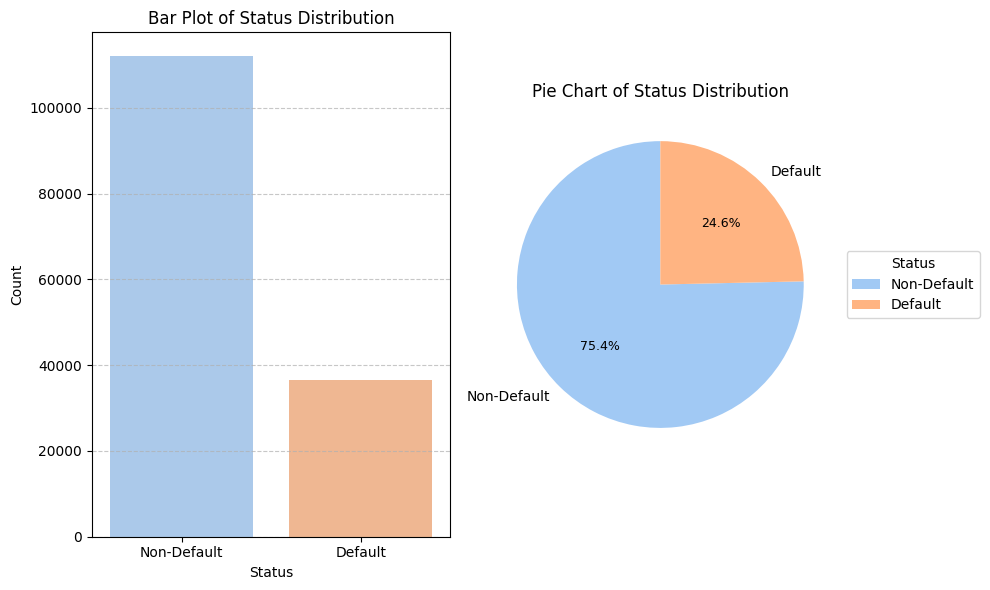

In [ ]:
# Step 1: Calculate value counts for the 'Status' column
status_counts = data['Status'].value_counts()

# Custom labels
custom_labels = {0: 'Non-Default', 1: 'Default'}
status_counts.index = [custom_labels[val] for val in status_counts.index]

# Step 2: Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # 1 row, 2 columns, adjusted height

# Subplot 1: Bar Plot
sns.barplot(
    x=status_counts.index,
    y=status_counts.values,
    ax=axes[0],
    palette='pastel'
)
axes[0].set_title('Bar Plot of Status Distribution')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Pie Chart
wedges, texts, autotexts = axes[1].pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel')[0:len(status_counts)]
)
axes[1].set_title('Pie Chart of Status Distribution')

# Customize labels for the pie chart
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(9)

# Add a legend to the pie chart
axes[1].legend(
    wedges,
    status_counts.index,
    title="Status",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Adjust layout
plt.tight_layout()
plt.show()




Key Takeaways:

* Since the class imbalance is quite drastic (75-25), we have taken the decision to handle it using SMOTE analysis. This will help our models learn effectively and not over-predict our majority class.

### Part 2.2.2 Feature Correlation

We will check the linear correlation of features in our dataset.

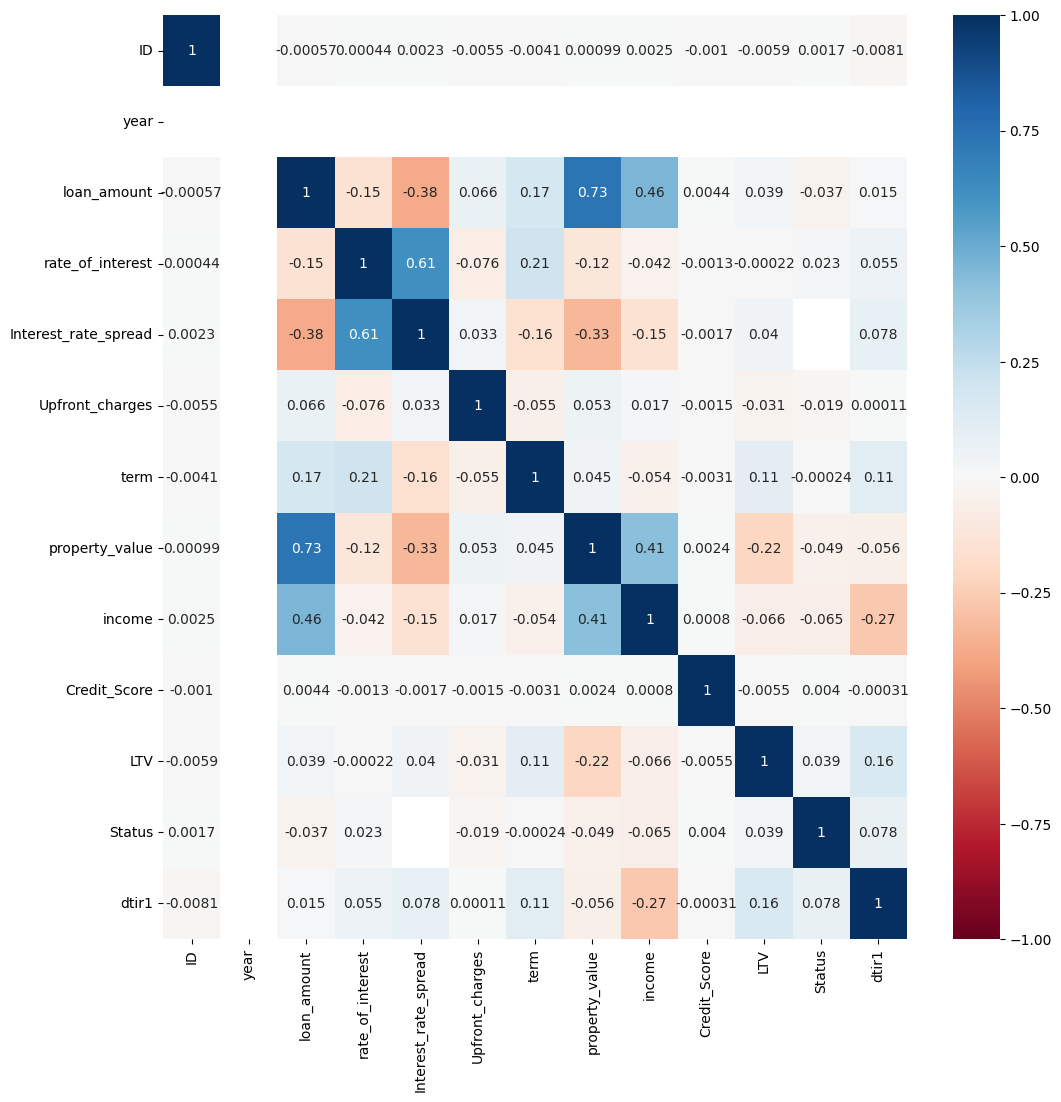

In [ ]:
import numpy as np
column_types = data.dtypes

# Select only the numeric columns
numeric_columns = data.select_dtypes(include=[np.number])

corr_mat = numeric_columns.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_mat, annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.show()

Because the previous heatmap only computes the correlation between numerical features, we implement the Spearman rank-order correlation metric to determine the correlation between the categorical variables and 'Status'.

<ipython-input-17-1becfebf712f>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spearman_series.index, y=spearman_series.values, palette='coolwarm')


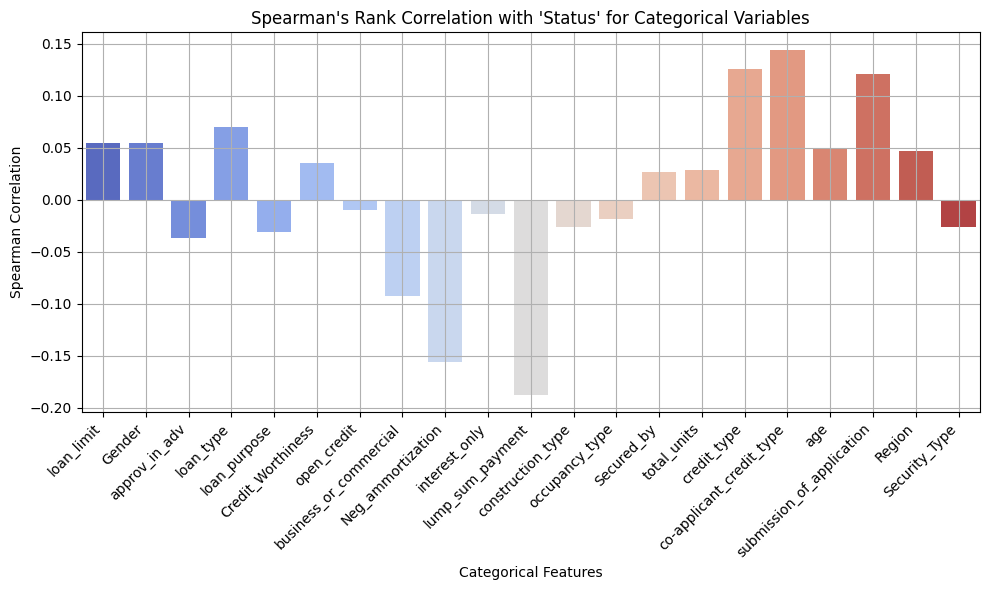

In [ ]:
# Create a copy of the dataframe
data_copy = data.copy()

# Identify categorical columns (excluding purely numerical columns)
categorical_columns = data_copy.select_dtypes(include=['object', 'category']).columns

# Prepare a dictionary to store the Spearman correlations for categorical variables
spearman_results = {}

# Calculate Spearman's correlation for each categorical feature against 'Status'
for col in categorical_columns:
    # Drop NaN values before calculating correlation
    data_copy_clean = data_copy.dropna(subset=[col, 'Status'])

    # Calculate Spearman's rank correlation
    correlation, p_value = spearmanr(data_copy_clean[col], data_copy_clean['Status'])

    # Store the results in the dictionary
    spearman_results[col] = correlation

# Convert the results dictionary into a pandas Series for easy plotting
spearman_series = pd.Series(spearman_results)

# Plot the Spearman correlations for categorical features
plt.figure(figsize=(10, 6))
sns.barplot(x=spearman_series.index, y=spearman_series.values, palette='coolwarm')
plt.title("Spearman's Rank Correlation with 'Status' for Categorical Variables")
plt.xlabel('Categorical Features')
plt.ylabel('Spearman Correlation')
plt.xticks(rotation=45, ha='right')
plt.grid(True)  # Add grid to the plot
plt.tight_layout()  # Adjust layout to fit the x-axis labels
plt.show()


We can see that none of the features have a high correlation with 'Status'.

KEY TAKEAWAY:

* Correlation measures linear relationships, but many real-world problems involve nonlinear relationships between features and the target. A combination of features can capture nonlinear relationships even when individual features do not show any.

* Advanced models like decision trees, random forests, and neural networks can identify these nonlinear patterns and use them for accurate predictions.



### Part 2.2.3 Exploring important numerical features

We want to explore the behavior of important numerical features like income, loan amount, and credit score that affect the probability of a person defaulting on a loan or not.


#### Part 2.2.3.1 Income Feature

We expect to see a left swek in our data as higher-income individuals might not require loans or may qualify for different types of financial products.

<ipython-input-18-fd4cf0e2c822>:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = data_copy.pivot_table(index='income_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()
<ipython-input-18-fd4cf0e2c822>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-18-fd4cf0e2c822>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


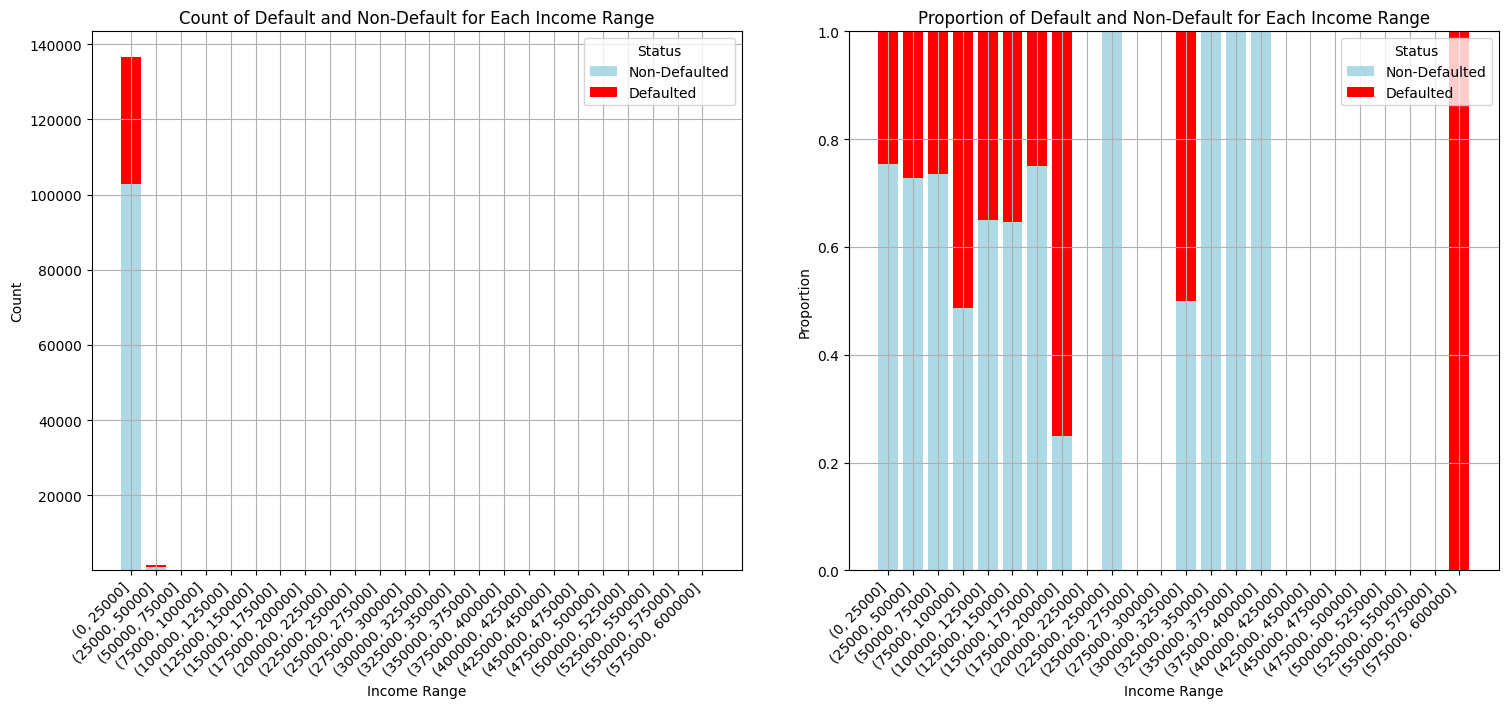

In [ ]:
# Create a copy of the dataframe
data_copy = data.copy()

# Define income bins (We go from minimum income in our dataset to the maximum income)
income_bins = range(int(data['income'].min()), int(data_copy['income'].max())+25000, 25000)  # 50,000 interval
data_copy['income_bin'] = pd.cut(data_copy['income'], bins=income_bins)

# Create a pivot table to handle missing combinations and fill them with zeros
pivot_table = data_copy.pivot_table(index='income_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()

# Rename columns for clarity
pivot_table.columns = ['income_bin', 'Non_Defaulted', 'Defaulted']

# Calculate total count for each income bin to determine proportions
pivot_table['Total'] = pivot_table['Non_Defaulted'] + pivot_table['Defaulted']
pivot_table['Proportion_Non_Defaulted'] = pivot_table['Non_Defaulted'] / pivot_table['Total']
pivot_table['Proportion_Defaulted'] = pivot_table['Defaulted'] / pivot_table['Total']

# Create subplots with two graphs
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the stacked bar for count of default and non-default for each loan amount bin
axes[0].bar(pivot_table['income_bin'].astype(str), pivot_table['Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[0].bar(pivot_table['income_bin'].astype(str), pivot_table['Defaulted'], bottom=pivot_table['Non_Defaulted'], color='red', label='Defaulted')

# Customize the count bar plot
axes[0].set_title('Count of Default and Non-Default for Each Income Range')
axes[0].set_xlabel('Income Range')
axes[0].set_ylabel('Count')
axes[0].legend(title='Status')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(True)

# Plot the stacked bar for proportion of default and non-default for each loan amount bin
axes[1].bar(pivot_table['income_bin'].astype(str), pivot_table['Proportion_Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[1].bar(pivot_table['income_bin'].astype(str), pivot_table['Proportion_Defaulted'], bottom=pivot_table['Proportion_Non_Defaulted'], color='red', label='Defaulted')

# Customize the proportion bar plot
axes[1].set_title('Proportion of Default and Non-Default for Each Income Range')
axes[1].set_xlabel('Income Range')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Status')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].grid(True)

# Adjust the layout to fit labels
plt.tight_layout(pad=4.0)  # Adjust the pad for more spacing
plt.subplots_adjust(hspace=1)
plt.grid(True)  # Add grid to the plots
plt.show()




We can see that our data does have a left skew, but majority of our data is between 0-5000, so let us explore that in a little more detail.

<ipython-input-26-53c4833df376>:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = data_copy.pivot_table(index='income_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()


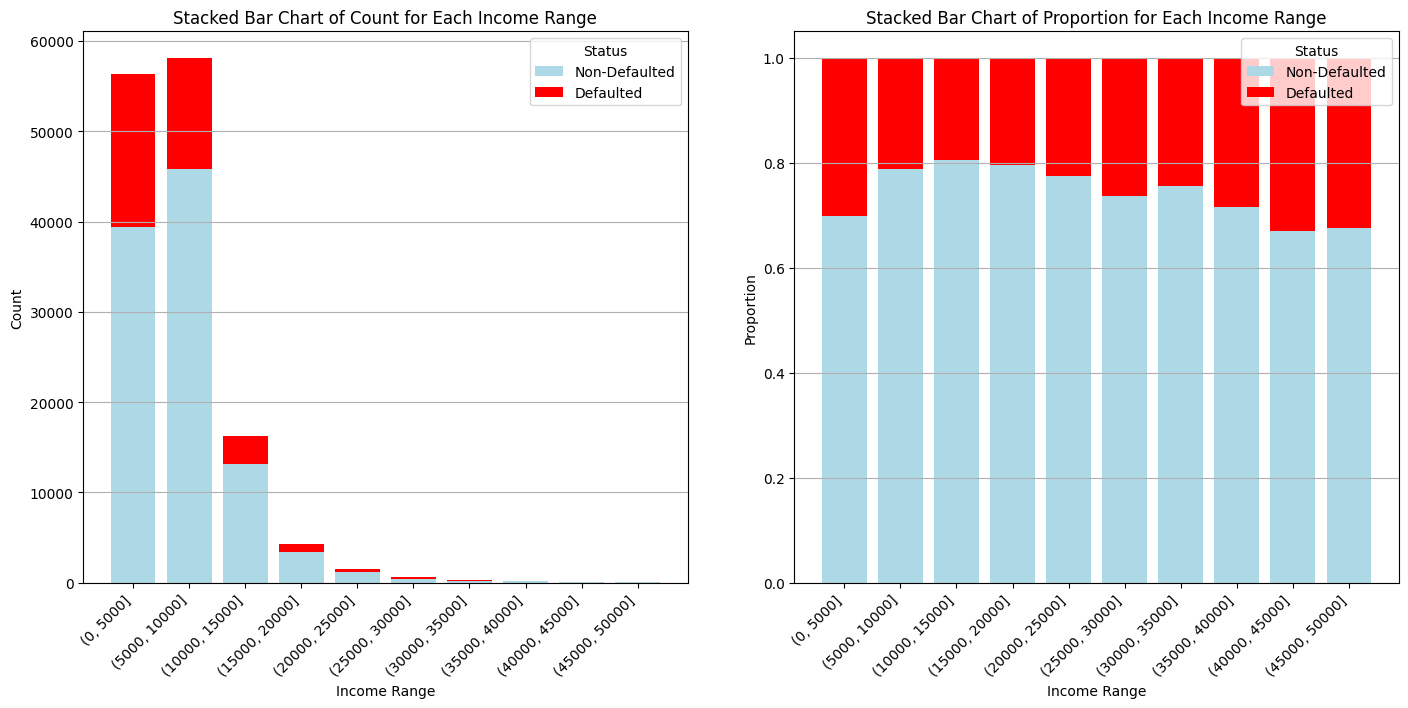

In [ ]:
# Create a copy of the dataframe
data_copy = data.copy()

# Define income bins (We are checking from 0 - 50,000)
income_bins = range(0, 55000, 5000)  # 5,000 interval
data_copy['income_bin'] = pd.cut(data_copy['income'], bins=income_bins)

# Create a pivot table to handle missing combinations and fill them with zeros
pivot_table = data_copy.pivot_table(index='income_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()

# Rename columns for clarity
pivot_table.columns = ['income_bin', 'Non_Defaulted', 'Defaulted']

# Calculate total count for each income bin to determine proportions
pivot_table['Total'] = pivot_table['Non_Defaulted'] + pivot_table['Defaulted']
pivot_table['Proportion_Non_Defaulted'] = pivot_table['Non_Defaulted'] / pivot_table['Total']
pivot_table['Proportion_Defaulted'] = pivot_table['Defaulted'] / pivot_table['Total']

# Set up the figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Subplot 1: Count (Stacked Bar)
bar_positions = np.arange(len(pivot_table['income_bin']))
ax1.bar(bar_positions, pivot_table['Non_Defaulted'], color='lightblue', label='Non-Defaulted')
ax1.bar(bar_positions, pivot_table['Defaulted'], bottom=pivot_table['Non_Defaulted'], color='red', label='Defaulted')
ax1.set_title('Stacked Bar Chart of Count for Each Income Range')
ax1.set_xlabel('Income Range')
ax1.set_ylabel('Count')
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(pivot_table['income_bin'], rotation=45, ha='right')
ax1.legend(title='Status')
# ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.yaxis.grid(True)

# Subplot 2: Proportion (Stacked Bar)
ax2.bar(bar_positions, pivot_table['Proportion_Non_Defaulted'], color='lightblue', label='Non-Defaulted')
ax2.bar(bar_positions, pivot_table['Proportion_Defaulted'], bottom=pivot_table['Proportion_Non_Defaulted'], color='red', label='Defaulted')
ax2.set_title('Stacked Bar Chart of Proportion for Each Income Range')
ax2.set_xlabel('Income Range')
ax2.set_ylabel('Proportion')
ax2.set_xticks(bar_positions)
ax2.set_xticklabels(pivot_table['income_bin'], rotation=45, ha='right')
ax2.legend(title='Status')
# ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.yaxis.grid(True)

# Adjust layout for both subplots
plt.tight_layout(pad=4.0)
plt.show()




Key Takeways:

* We still observe a left skew in our data, so our initial assumption was correct.
* The proportion of 'default' and 'non-default' cases remains roughly similar with respect to income. We see a slight increase in non-defaults as income increases, but it eventually comes back down.

#### Part 2.2.3.2 Loan Amount

As we know from our correlation matrix above there is a correlation between 'loan amount' and 'income'; we expect to see a left seek here as well.

<ipython-input-20-6669421d0d8a>:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = data_copy.pivot_table(index='loan_amount_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()
<ipython-input-20-6669421d0d8a>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-20-6669421d0d8a>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


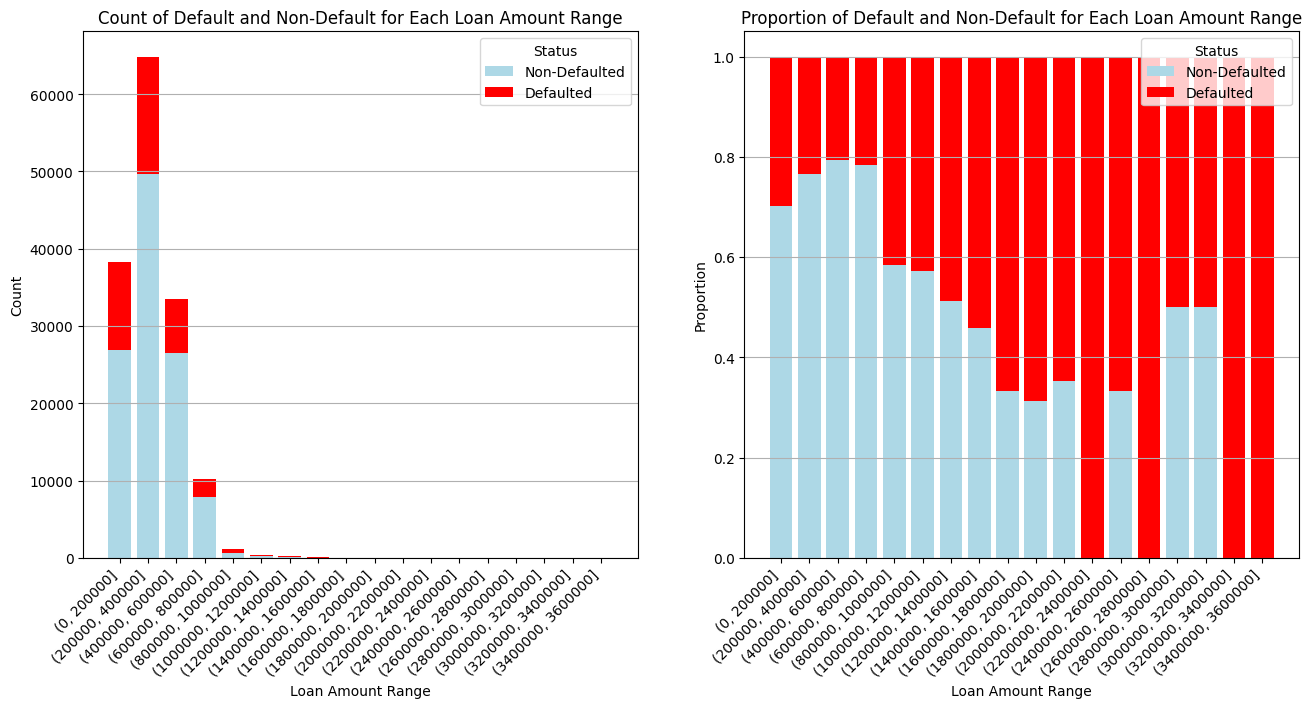

In [ ]:
# Create a copy of the dataframe
data_copy = data.copy()

# Define loan amount bins (We start from 0 as we know from our data.describe() output that our minimum loan amount is greater than 0)
loan_amount_bins = range(0, data_copy['loan_amount'].max() + 200000, 200000)  # Interval size 200,000
data_copy['loan_amount_bin'] = pd.cut(data_copy['loan_amount'], bins=loan_amount_bins)

# Create a pivot table to count defaulters and non-defaulters in each loan amount bin
pivot_table = data_copy.pivot_table(index='loan_amount_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()

# Rename columns for clarity
pivot_table.columns = ['loan_amount_bin', 'Non_Defaulted', 'Defaulted']

# Calculate total count for each loan amount bin to determine proportions
pivot_table['Total'] = pivot_table['Non_Defaulted'] + pivot_table['Defaulted']
pivot_table['Proportion_Non_Defaulted'] = pivot_table['Non_Defaulted'] / pivot_table['Total']
pivot_table['Proportion_Defaulted'] = pivot_table['Defaulted'] / pivot_table['Total']

# Create subplots with two graphs
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot the stacked bar for count of default and non-default for each loan amount bin
axes[0].bar(pivot_table['loan_amount_bin'].astype(str), pivot_table['Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[0].bar(pivot_table['loan_amount_bin'].astype(str), pivot_table['Defaulted'], bottom=pivot_table['Non_Defaulted'], color='red', label='Defaulted')

# Customize the count bar plot
axes[0].set_title('Count of Default and Non-Default for Each Loan Amount Range')
axes[0].set_xlabel('Loan Amount Range')
axes[0].set_ylabel('Count')
axes[0].legend(title='Status')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].yaxis.grid(True)

# Plot the stacked bar for proportion of default and non-default for each loan amount bin
axes[1].bar(pivot_table['loan_amount_bin'].astype(str), pivot_table['Proportion_Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[1].bar(pivot_table['loan_amount_bin'].astype(str), pivot_table['Proportion_Defaulted'], bottom=pivot_table['Proportion_Non_Defaulted'], color='red', label='Defaulted')

# Customize the proportion bar plot
axes[1].set_title('Proportion of Default and Non-Default for Each Loan Amount Range')
axes[1].set_xlabel('Loan Amount Range')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Status')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].yaxis.grid(True)

# Adjust the layout to fit labels
plt.tight_layout(pad=4.0)  # Adjust the pad for more spacing
plt.subplots_adjust(hspace=1)
# plt.grid(True)  # Add grid to the plots
plt.show()




Key Takeaways:
* Again we see the left skew in our data that we expected to see, which checks out as people with lower incomes will usually get approved for loans of lower amounts. This is because it becomes highly unlikely for a bank to approve of a loan as it has reason to believe that a person with a lower income will not be able to generate enough money to pay back their loans.

* We also see that beyond a point (2.2 million), the loan is extremely likely to default, which is intuitive because people will generally find it more difficult to pay up larger amounts of loan.

* We can also see that majority of our data is contained with loan values less than 800,000, so we will explore this part further.

<ipython-input-21-7b745394e930>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_copy['loan_amount_bin'] = pd.cut(data_copy['loan_amount'], bins=loan_amount_bins)
<ipython-input-21-7b745394e930>:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = data_copy.pivot_table(index='loan_amount_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()
<ipython-input-21-7b745394e930>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rot

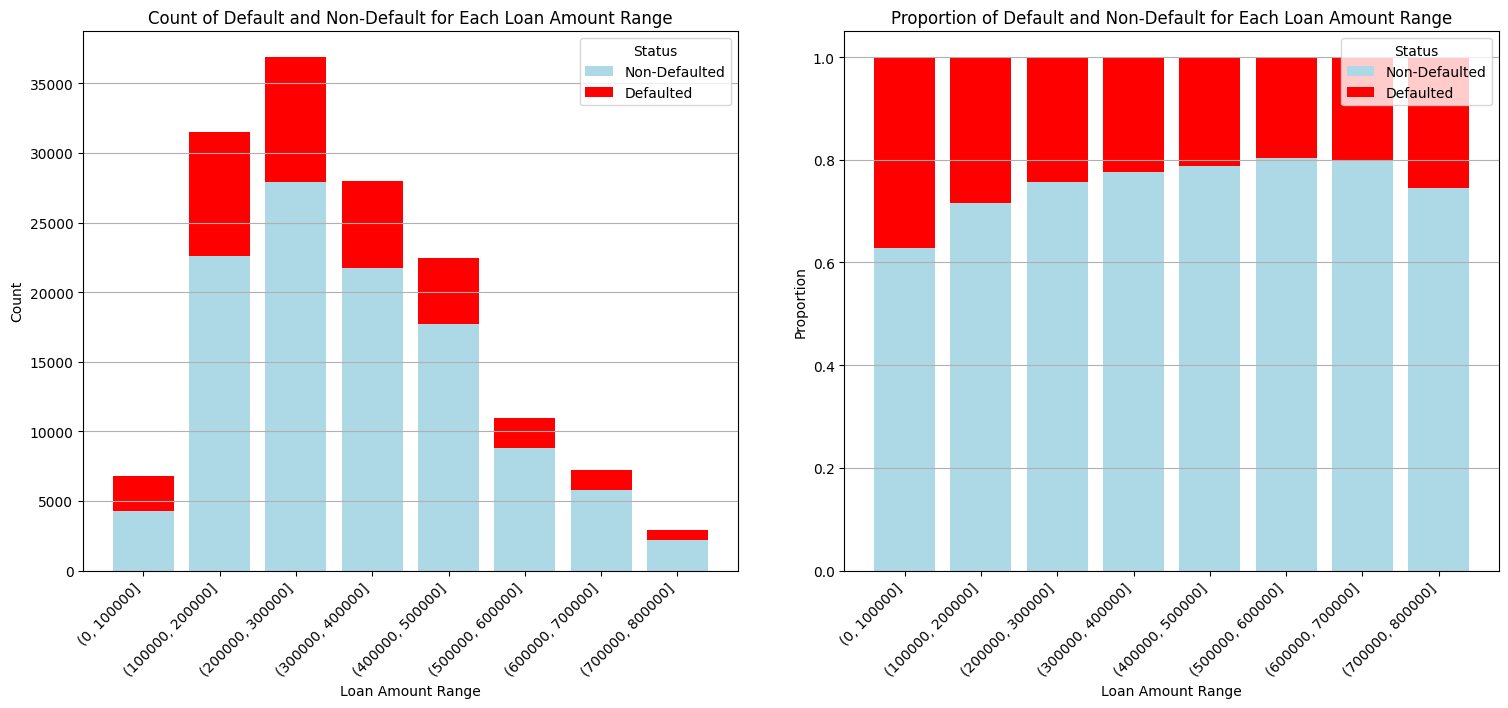

In [ ]:
# Create a copy of the dataframe
data_copy = data[data['loan_amount'] < 800000]

# Define loan amount bins
loan_amount_bins = range(0, data_copy['loan_amount'].max() + 100000, 100000)  # Interval size 100,000
data_copy['loan_amount_bin'] = pd.cut(data_copy['loan_amount'], bins=loan_amount_bins)

# Create a pivot table to count defaulters and non-defaulters in each loan amount bin
pivot_table = data_copy.pivot_table(index='loan_amount_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()

# Rename columns for clarity
pivot_table.columns = ['loan_amount_bin', 'Non_Defaulted', 'Defaulted']

# Calculate total count for each loan amount bin to determine proportions
pivot_table['Total'] = pivot_table['Non_Defaulted'] + pivot_table['Defaulted']
pivot_table['Proportion_Non_Defaulted'] = pivot_table['Non_Defaulted'] / pivot_table['Total']
pivot_table['Proportion_Defaulted'] = pivot_table['Defaulted'] / pivot_table['Total']

# Create subplots with two graphs
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the stacked bar for count of default and non-default for each loan amount bin
axes[0].bar(pivot_table['loan_amount_bin'].astype(str), pivot_table['Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[0].bar(pivot_table['loan_amount_bin'].astype(str), pivot_table['Defaulted'], bottom=pivot_table['Non_Defaulted'], color='red', label='Defaulted')

# Customize the count bar plot
axes[0].set_title('Count of Default and Non-Default for Each Loan Amount Range')
axes[0].set_xlabel('Loan Amount Range')
axes[0].set_ylabel('Count')
axes[0].legend(title='Status')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].yaxis.grid(True)

# Plot the stacked bar for proportion of default and non-default for each loan amount bin
axes[1].bar(pivot_table['loan_amount_bin'].astype(str), pivot_table['Proportion_Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[1].bar(pivot_table['loan_amount_bin'].astype(str), pivot_table['Proportion_Defaulted'], bottom=pivot_table['Proportion_Non_Defaulted'], color='red', label='Defaulted')

# Customize the proportion bar plot
axes[1].set_title('Proportion of Default and Non-Default for Each Loan Amount Range')
axes[1].set_xlabel('Loan Amount Range')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Status')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].yaxis.grid(True)

# Adjust the layout to fit labels
plt.tight_layout(pad=4.0)  # Adjust the pad for more spacing
plt.subplots_adjust(hspace=1)
# plt.grid(True)  # Add grid to the plots
plt.show()




Key Takeaways:
* Again, we see the left skew that we expected.
* As the loan amount increases, we see a steady increase in the proportion of non-defaulters, but then it goes back down. This increase is seen in the parent graph also from 0 - 800,000. This could be because small loans are often unsecured and used for immediate needs (e.g., paying bills, emergencies), where defaults may occur if borrowers face financial instability. Whereas, larger loans could be typically secured (e.g., mortgages, car loans) or tied to assets, making borrowers more committed to repayment.
* The majority of our borrowers fall between the 100,000 and 500,000 range.

#### Part 2.2.3.3 Credit Score



<ipython-input-23-e0fbe86ca72b>:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = data_copy.pivot_table(index='credit_score_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()
<ipython-input-23-e0fbe86ca72b>:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-23-e0fbe86ca72b>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


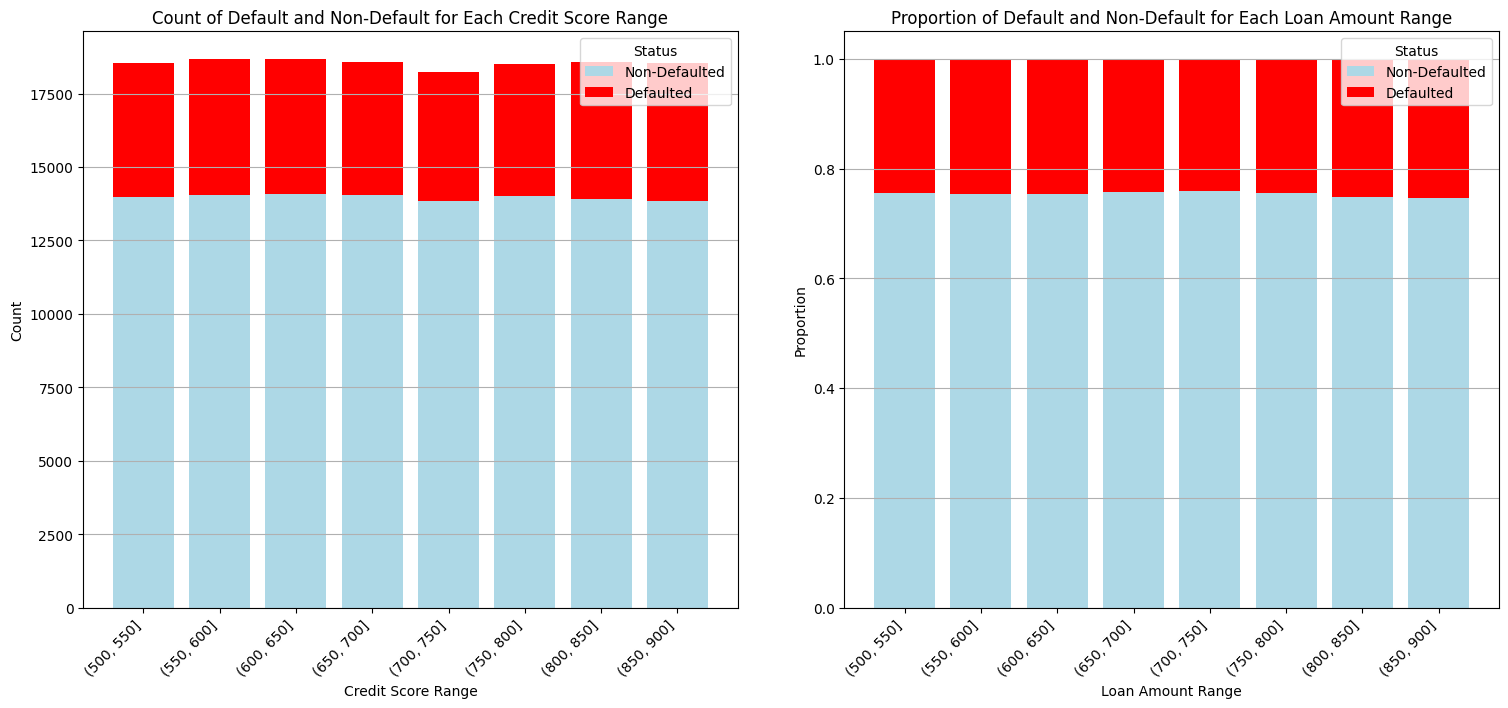

In [ ]:
# Create a copy of the dataframe
data_copy = data.copy()

# Define loan amount bins (From minimum credit score to maximum)
loan_amount_bins = range(data_copy['Credit_Score'].min(), data_copy['Credit_Score'].max() + 50, 50)  # Interval size 50
data_copy['credit_score_bin'] = pd.cut(data_copy['Credit_Score'], bins=loan_amount_bins)

# Create a pivot table to count defaulters and non-defaulters in each loan amount bin
pivot_table = data_copy.pivot_table(index='credit_score_bin', columns='Status', aggfunc='size', fill_value=0).reset_index()

# Rename columns for clarity
pivot_table.columns = ['credit_score_bin', 'Non_Defaulted', 'Defaulted']

# Calculate total count for each loan amount bin to determine proportions
pivot_table['Total'] = pivot_table['Non_Defaulted'] + pivot_table['Defaulted']
pivot_table['Proportion_Non_Defaulted'] = pivot_table['Non_Defaulted'] / pivot_table['Total']
pivot_table['Proportion_Defaulted'] = pivot_table['Defaulted'] / pivot_table['Total']

# Create subplots with two graphs
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the stacked bar for count of default and non-default for each loan amount bin
axes[0].bar(pivot_table['credit_score_bin'].astype(str), pivot_table['Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[0].bar(pivot_table['credit_score_bin'].astype(str), pivot_table['Defaulted'], bottom=pivot_table['Non_Defaulted'], color='red', label='Defaulted')

# Customize the count bar plot
axes[0].set_title('Count of Default and Non-Default for Each Credit Score Range')
axes[0].set_xlabel('Credit Score Range')
axes[0].set_ylabel('Count')
axes[0].legend(title='Status')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].yaxis.grid(True)

# Plot the stacked bar for proportion of default and non-default for each loan amount bin
axes[1].bar(pivot_table['credit_score_bin'].astype(str), pivot_table['Proportion_Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[1].bar(pivot_table['credit_score_bin'].astype(str), pivot_table['Proportion_Defaulted'], bottom=pivot_table['Proportion_Non_Defaulted'], color='red', label='Defaulted')

# Customize the proportion bar plot
axes[1].set_title('Proportion of Default and Non-Default for Each Loan Amount Range')
axes[1].set_xlabel('Loan Amount Range')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Status')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].yaxis.grid(True)

# Adjust the layout to fit labels
plt.tight_layout(pad=4.0)  # Adjust the pad for more spacing
plt.subplots_adjust(hspace=1)
# plt.grid(True)  # Add grid to the plots
plt.show()




Key Takeaways:
* Our borrowers are fairly evenly divided into separate bins of credit scores.
* The proportion of defaulting across all credit scores remains relatively equal. This could be because in our dataset all credit scores are generally high (i.e., the minimum is 500). So, since the credit score is generally high, it stops playing a big role in seeing if a person defaults on the loan or not.

### Part 2.2.4 Exploring demographic features

We want to explore the behavior of demographic features like gender, and age that affect the probability of a person defaulting on a loan or not.

#### Part 2.2.4.1 Gender

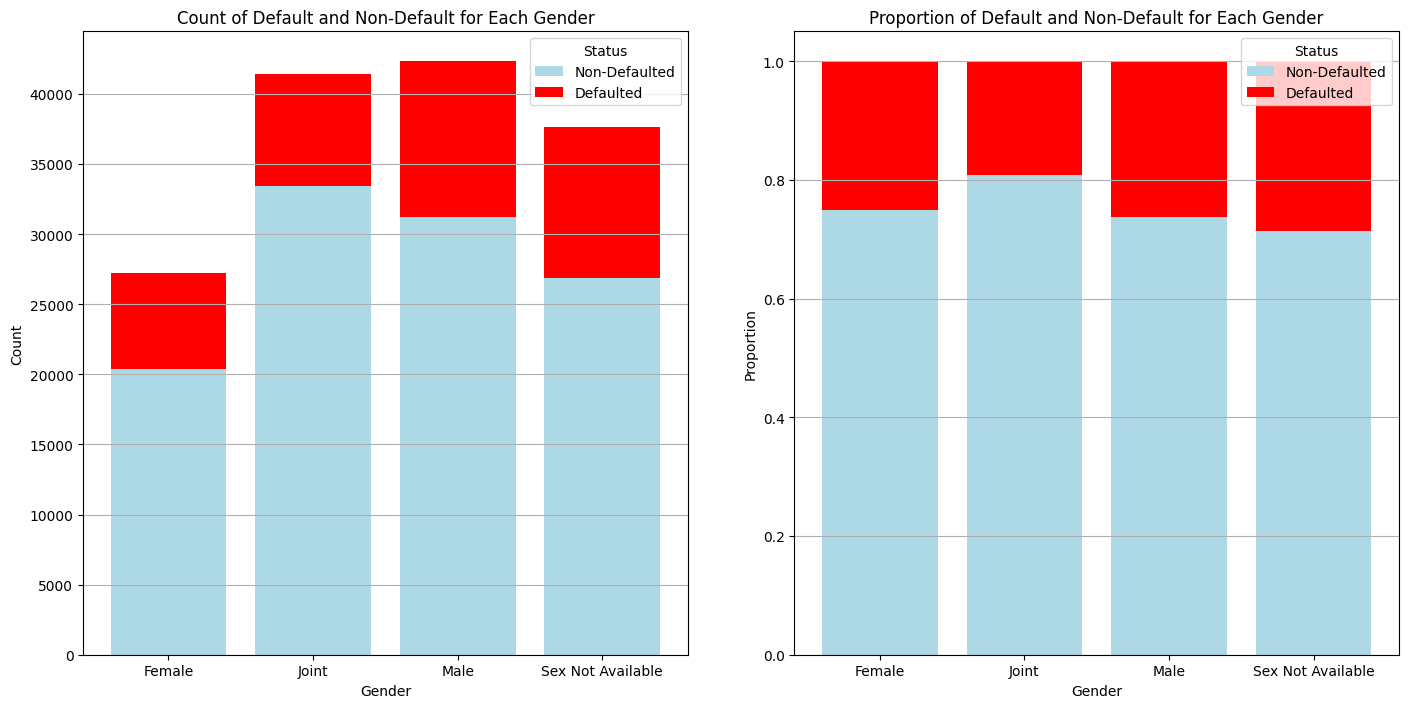

In [ ]:
# Create a copy of the dataframe
data_copy = data.copy()

# Create a pivot table to handle counts for each gender and fill missing combinations with zeros
pivot_table_gender = data_copy.pivot_table(index='Gender', columns='Status', aggfunc='size', fill_value=0).reset_index()

# Rename columns for clarity
pivot_table_gender.columns = ['gender', 'Non_Defaulted', 'Defaulted']

# Calculate total count for each gender to determine proportions
pivot_table_gender['Total'] = pivot_table_gender['Non_Defaulted'] + pivot_table_gender['Defaulted']
pivot_table_gender['Proportion_Non_Defaulted'] = pivot_table_gender['Non_Defaulted'] / pivot_table_gender['Total']
pivot_table_gender['Proportion_Defaulted'] = pivot_table_gender['Defaulted'] / pivot_table_gender['Total']

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharex=True)

# Plot the stacked bar for count of default and non-default for each gender
axes[0].bar(pivot_table_gender['gender'], pivot_table_gender['Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[0].bar(pivot_table_gender['gender'], pivot_table_gender['Defaulted'], bottom=pivot_table_gender['Non_Defaulted'], color='red', label='Defaulted')

# Customize the count bar plot
axes[0].set_title('Count of Default and Non-Default for Each Gender')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].legend(title='Status')
axes[0].grid(axis='y')  # Add horizontal grid lines

# Plot the stacked bar for proportion of default and non-default for each gender
axes[1].bar(pivot_table_gender['gender'], pivot_table_gender['Proportion_Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[1].bar(pivot_table_gender['gender'], pivot_table_gender['Proportion_Defaulted'], bottom=pivot_table_gender['Proportion_Non_Defaulted'], color='red', label='Defaulted')

# Customize the proportion bar plot
axes[1].set_title('Proportion of Default and Non-Default for Each Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Status')
axes[1].grid(axis='y')  # Add horizontal grid lines

# Adjust layout to make it look neat
plt.tight_layout(pad=4.0)
plt.show()




Key Takeaways:
* We can see that the proportion of default and non-default cases, remain relatively similar irrespective of gender, which is what we would expect as gender is completely irrelevant to a person defaulting on their loan or not. The other parameters in the dataset likely explain the factors that affect whether a person defaults on their loan or not.

#### Part 2.2.4.2 Age

<ipython-input-25-18778a3448a3>:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table_gender = data_copy.pivot_table(index='age', columns='Status', aggfunc='size', fill_value=0).reset_index()


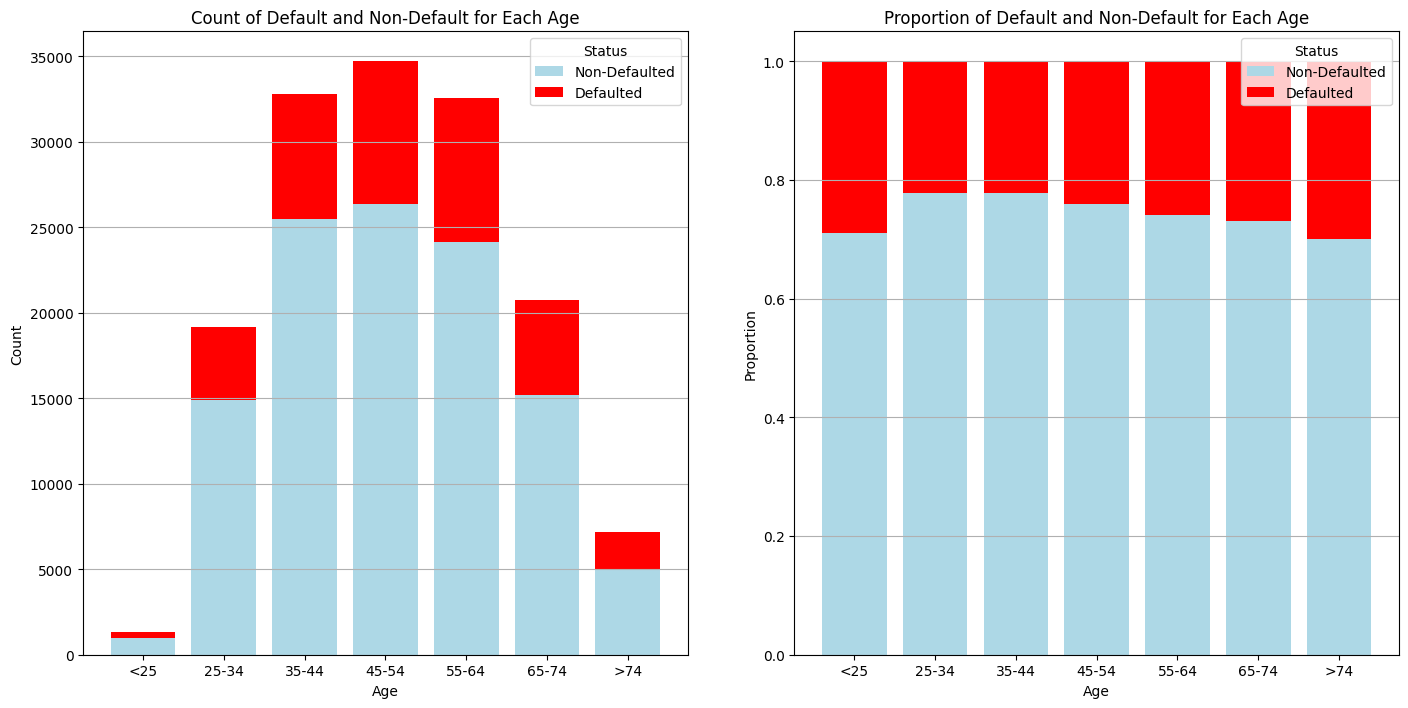

In [ ]:
# Create a copy of the dataframe
data_copy = data.copy()

age_order = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '>74']

# Convert the 'age' column to a categorical type with a specific order
data_copy['age'] = pd.Categorical(data_copy['age'], categories=age_order, ordered=True)

# Create a pivot table to handle counts for each gender and fill missing combinations with zeros
pivot_table_gender = data_copy.pivot_table(index='age', columns='Status', aggfunc='size', fill_value=0).reset_index()

# Rename columns for clarity
pivot_table_gender.columns = ['age', 'Non_Defaulted', 'Defaulted']

# Calculate total count for each gender to determine proportions
pivot_table_gender['Total'] = pivot_table_gender['Non_Defaulted'] + pivot_table_gender['Defaulted']
pivot_table_gender['Proportion_Non_Defaulted'] = pivot_table_gender['Non_Defaulted'] / pivot_table_gender['Total']
pivot_table_gender['Proportion_Defaulted'] = pivot_table_gender['Defaulted'] / pivot_table_gender['Total']

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharex=True)

# Plot the stacked bar for count of default and non-default for each gender
axes[0].bar(pivot_table_gender['age'], pivot_table_gender['Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[0].bar(pivot_table_gender['age'], pivot_table_gender['Defaulted'], bottom=pivot_table_gender['Non_Defaulted'], color='red', label='Defaulted')

# Customize the count bar plot
axes[0].set_title('Count of Default and Non-Default for Each Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].legend(title='Status')
axes[0].grid(axis='y')  # Add horizontal grid lines

# Plot the stacked bar for proportion of default and non-default for each gender
axes[1].bar(pivot_table_gender['age'], pivot_table_gender['Proportion_Non_Defaulted'], color='lightblue', label='Non-Defaulted')
axes[1].bar(pivot_table_gender['age'], pivot_table_gender['Proportion_Defaulted'], bottom=pivot_table_gender['Proportion_Non_Defaulted'], color='red', label='Defaulted')

# Customize the proportion bar plot
axes[1].set_title('Proportion of Default and Non-Default for Each Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Status')
axes[1].grid(axis='y')  # Add horizontal grid lines

# Adjust layout to make it look neat
plt.tight_layout(pad=4.0)
plt.show()




Key Takeaways:
* We can see that the proportion of default and non-default cases, remain relatively similar irrespective of age, which is what we would expect as age is completely irrelevant to a person defaulting on their loan or not. The other parameters in the dataset likely explain the factors that affect whether a person defaults on their loan or not.
* Majority of loan borrowers are between the age of 35-64. This makes sense, as in general people borrow loans mainly in their middle ages.


From our EDA, it is clear that gender and age do not play a role in whether a person will default on their loan or not. As ethical data scientists, it is essential to minimize any potential bias in our model, particularly concerning sensitive attributes like age and gender. Since there is no causal relationship between gender/age and loan status, we do not want our model to implicitly learn any unwanted correlations either. Therefore, we have taken the decision to remove these features from our training and testing data.

### Part 2.2.5 Null Value Percentages

We will find the percentage of null values for each feature.

<ipython-input-22-1c4fa3c70648>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Column', y='Null Percentage', data=null_percentage_df, palette='brg')


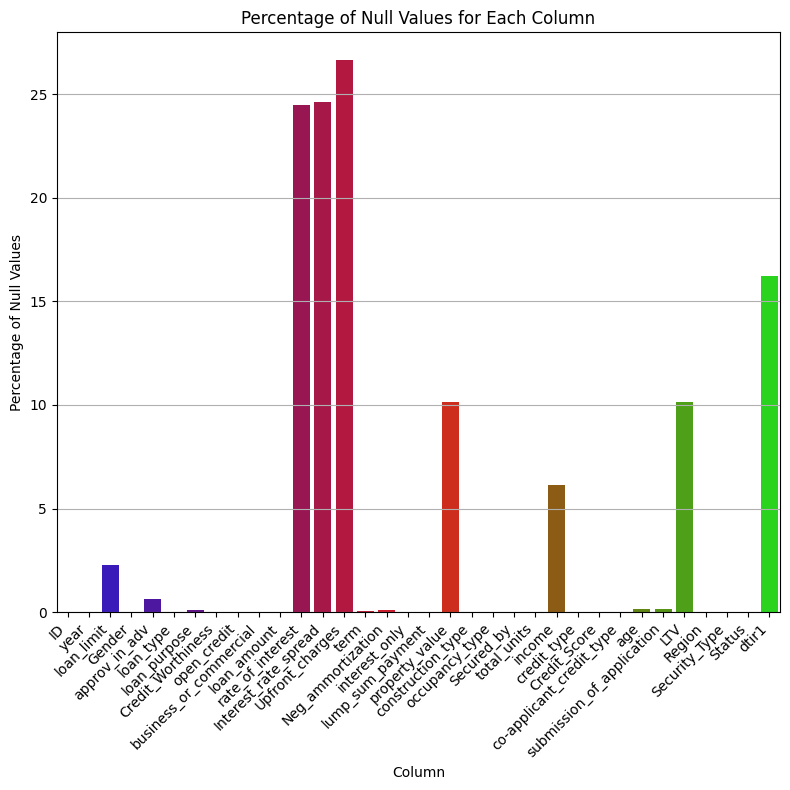

In [ ]:
# Calculate the percentage of null values for each column
null_percentage = data.isnull().mean() * 100

# Convert to DataFrame for easier plotting
null_percentage_df = pd.DataFrame({
    'Column': null_percentage.index,
    'Null Percentage': null_percentage.values
})

# Set up the plot with Seaborn
plt.figure(figsize=(8, 8))
sns.barplot(x='Column', y='Null Percentage', data=null_percentage_df, palette='brg')

# Add plot titles and labels
plt.title('Percentage of Null Values for Each Column')
plt.xlabel('Column')
plt.ylabel('Percentage of Null Values')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')


# Adjust layout and display the plot
plt.tight_layout()
plt.grid(axis='y')
plt.show()




Key Takeaways:
* No singular column has so many null values such that we need to drop it.
* The spread of null values among many columns does make it impractical to just drop them. If we drop them then we will be dropping a majority chunk of our dataset, which is unacceptable.
* Since majority of the null values are from numerical columns, we have decided to use advanced imputing techniques like KNN Imputer to handle them.

### Part 2.2.6 Outlier Values

We determine if a value is an outlier if it is less than 1.5\*IQR from Q1 or more than 1.5\*IQR from Q3.

In [ ]:
numeric_data = data.select_dtypes(include=['number'])
numeric_data = numeric_data.drop(columns=['Status'], axis=1)
numeric_data.head()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,dtir1
0,24890,2019,116500,NaN,NaN,NaN,360.0,118000.0,1740.0,758,98.728814,45.0
1,24891,2019,206500,NaN,NaN,NaN,360.0,NaN,4980.0,552,NaN,NaN
2,24892,2019,406500,4.56,0.2000,595.0,360.0,508000.0,9480.0,834,80.019685,46.0
3,24893,2019,456500,4.25,0.6810,NaN,360.0,658000.0,11880.0,587,69.376900,42.0
4,24894,2019,696500,4.00,0.3042,0.0,360.0,758000.0,10440.0,602,91.886544,39.0


<ipython-input-18-ab75953c4029>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outliers_df, x='Column', y='Percentage of Outliers', palette='tab20')


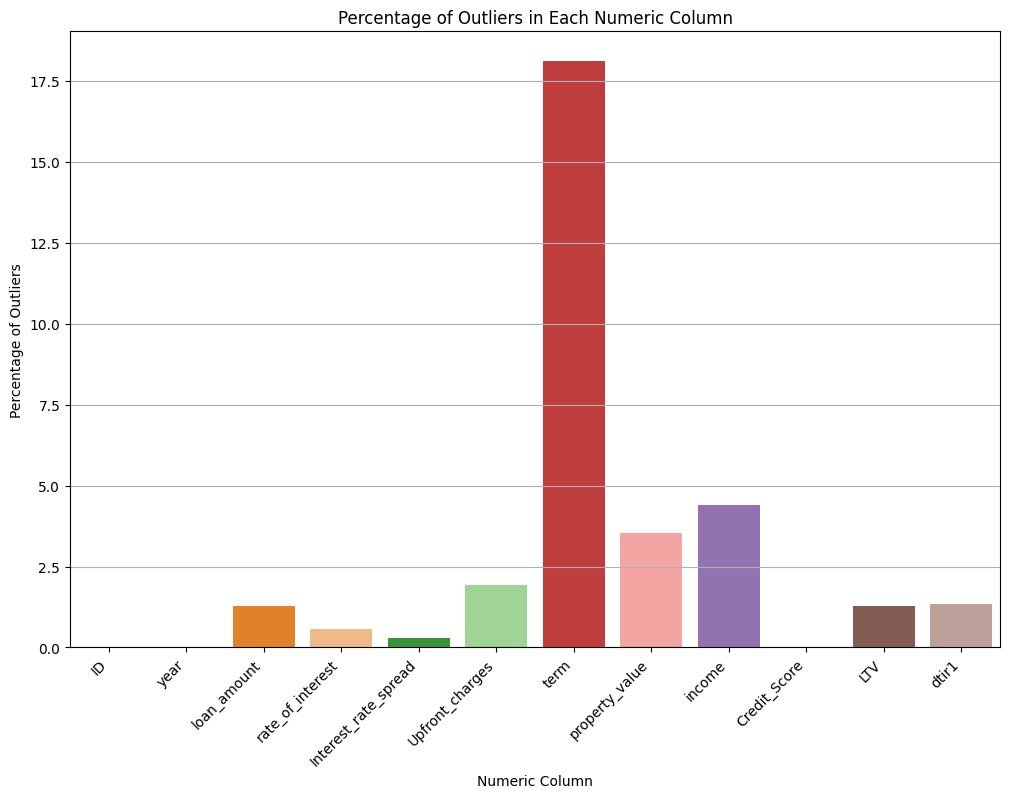

In [ ]:
# Create a copy of the dataframe with only numeric columns
numeric_data = data.select_dtypes(include=['number'])
numeric_data = numeric_data.drop(columns=['Status'], axis=1)

# Initialize a list to store the percentage of outliers for each numeric column
outlier_percentages = []

# Iterate over each numeric column to calculate the percentage of outliers based on the 1.5*IQR rule
for column in numeric_data.columns:
    Q1 = numeric_data[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = numeric_data[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile Range

    # Calculate lower and upper thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    num_outliers = numeric_data[(numeric_data[column] < lower_bound) | (numeric_data[column] > upper_bound)].shape[0]

    # Calculate the percentage of outliers
    percentage_outliers = (num_outliers / numeric_data[column].shape[0]) * 100
    outlier_percentages.append({'Column': column, 'Percentage of Outliers': percentage_outliers})

# Create a DataFrame to hold outlier percentages
outliers_df = pd.DataFrame(outlier_percentages)

# Plot the graph
plt.figure(figsize=(12, 8))
sns.barplot(data=outliers_df, x='Column', y='Percentage of Outliers', palette='tab20')
plt.title('Percentage of Outliers in Each Numeric Column')
plt.xlabel('Numeric Column')
plt.ylabel('Percentage of Outliers')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')  # Show only horizontal grid lines
plt.show()




Key Takeaways:
* Since we can see that 'Term' has roughly 18% of outliers in it, we cannot just drop them from our data. This will result in us dropping a major chunk of our dataset.
* Since we won't be dropping outliers, we believe that tree-based models like RFC or XGB will perform well with this data as they are robust in handling outliers.

### Part 2.2.7 Identifying and Removing Redundant Categorical Columns (Feature Selection)

To ensure our model remains efficient and avoids learning from redundant or uninformative data, we analyze categorical columns to identify those dominated by a single value. If a categorical column has the vast majority of its entries concentrated in one particular value (i.e., the mode), it fails to provide meaningful variability or insights for the model. Retaining such columns forces the model to account for extremely rare instances where the value deviates from the mode, which adds unnecessary complexity without contributing to predictive performance.

To address this, we will calculate the percentage of the mode for all categorical columns and visualize the results. Columns where the mode accounts for more than 95% of the values will be considered redundant and dropped. By removing these columns, we simplify the model, reduce noise, and enhance its ability to generalize, ultimately improving performance and interpretability.

loan_limit 93.13405722307088 cf
Gender 28.483217865070287 Male
approv_in_adv 84.33900461553037 nopre
loan_type 76.1236295150333 type1
loan_purpose 37.65686432918619 p3
Credit_Worthiness 95.74493845429475 l1
open_credit 99.62601735387099 nopc
business_or_commercial 86.03484226811058 nob/c
Neg_ammortization 89.81548176022727 not_neg
interest_only 95.21759601802651 not_int
lump_sum_payment 97.72381785161768 not_lpsm
construction_type 99.97780318826932 sb
occupancy_type 92.95822963610682 pr
Secured_by 99.97780318826932 home
total_units 98.52693885787313 1U
credit_type 32.388511468352725 CIB
co-applicant_credit_type 50.0383399475348 CIB
age 23.385195662423385 45-54
submission_of_application 64.53424934330168 to_inst
Region 50.260308064841595 North
Security_Type 99.97780318826932 direct


<ipython-input-24-853ab4007062>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Column', y='Percentage of Most Frequent Category', data=category_percentage_df, palette='Spectral')


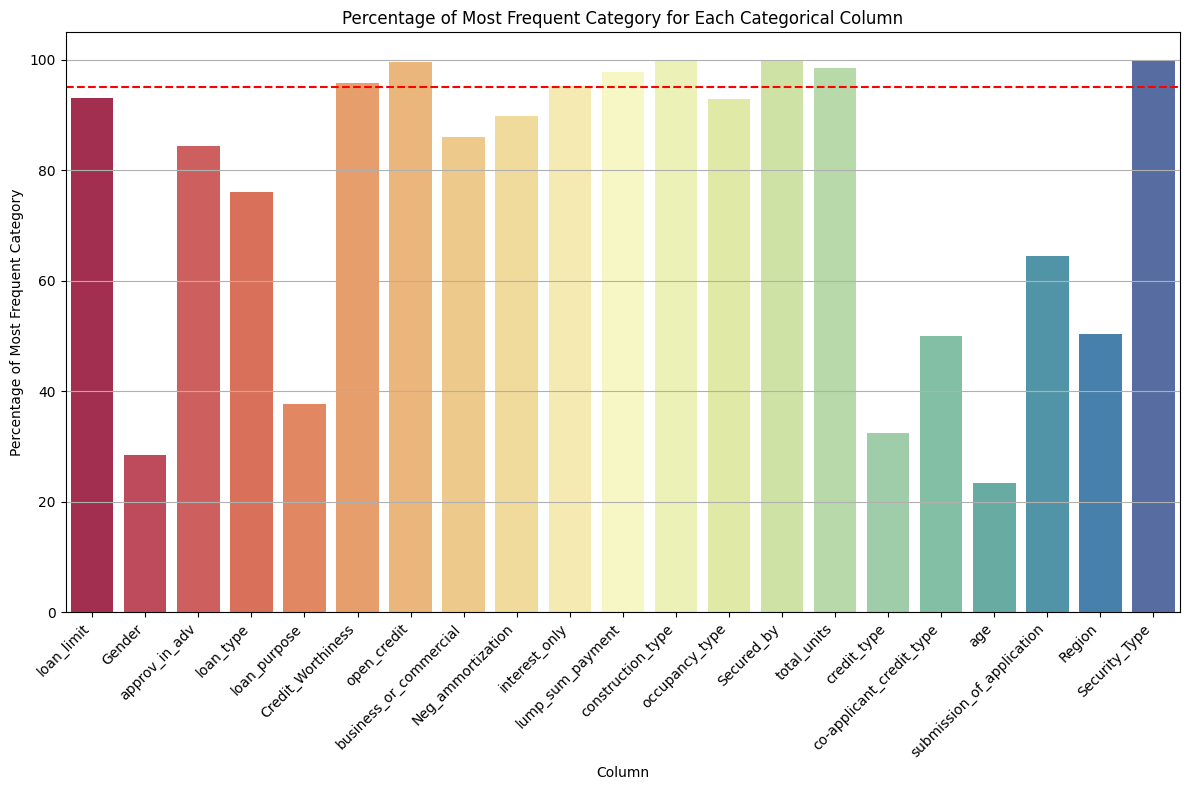

In [ ]:
# Select categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Initialize a dictionary to store the percentage of the highest occurrence for each categorical column
category_percentage = {}

# Calculate the percentage of the highest occurrence for each categorical column
for col in categorical_cols:
    # Exclude null values
    non_null_data = data[col].dropna()

    # Find the most frequent category (mode)
    most_frequent_category = non_null_data.mode()[0]

    # Calculate the count of the most frequent category
    most_frequent_count = (non_null_data == most_frequent_category).sum()

    # Calculate the percentage of the most frequent category
    category_percentage[col] = (most_frequent_count / len(non_null_data)) * 100
    print(col, category_percentage[col], most_frequent_category)

# Convert the dictionary to a DataFrame for easier plotting
category_percentage_df = pd.DataFrame({
    'Column': category_percentage.keys(),
    'Percentage of Most Frequent Category': category_percentage.values()
})

# Set up the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Column', y='Percentage of Most Frequent Category', data=category_percentage_df, palette='Spectral')

# Add plot titles and labels
plt.title('Percentage of Most Frequent Category for Each Categorical Column')
plt.xlabel('Column')
plt.ylabel('Percentage of Most Frequent Category')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.axhline(y=95, color='red', linestyle='--', label='95% Threshold')

# Show the y-axis line and gridlines
plt.grid(axis='y')  # Only apply grid to x-axis
# plt.gca().spines['left'].set_visible(True)  # Ensure the y-axis line is visible

# Adjust layout and display the plot
plt.tight_layout()
plt.show()




We identified that the columns 'Credit_Worthiness', 'open_credit', 'interest_only', 'lump_sum_payment', 'construction_type', 'Secured_by', 'total_units', and 'Security_Type' have their mode accounting for more than 95% of the values. As these columns provide minimal variability and do not contribute meaningful information to the model, we will drop them to reduce complexity and improve efficiency.

Additionally, we will remove the 'year' column, as the dataset exclusively represents the year 2019, offering no variability. The 'ID' column, being a unique identifier for each row, also does not provide any predictive value and will be excluded from the data.

Major Takeaways from EDA:

* We need to use SMOTE for handling our class imbalance.
* Our data does not have linear relationships between 'Status' and any feature in the dataset, which indicates that we need to learn non-linear features from our data. Therefore, we will be exploring models like RFC, XGB, and Neural Networks to help capture these non-linear relationships.
* We will handle null values using advanced techniques like KNN Imputer as a big chunk of our numeric data has null values.
* We have many outliers in our data that we cannot drop, so we will be exploring tree-based models like RFC and XGB which are robust in handling outliers.
* We will drop features of 'Gender' and 'age' to ensure fairness of our model
* We will drop 'Credit_Worthiness', 'open_credit', 'interest_only', 'lump_sum_payment', 'construction_type', 'Secured_by', 'total_units', and 'Security_Type' as they do not provide variability and do not provide meaningful information to our model.
* We will remove 'year' and 'ID' as they also do not provide helpful information.


#**Part 3: Data Preprocessing and Preparation**

In this part, we preprocess the dataset to make it suitable for our models. The process includes handling missing values, encoding categorical variables, addressing class imbalance, and scaling numerical features. Finally, we train multiple models and evaluate their performance.

###**Part 3.1: Splitting Features, Target Variables and Train - Test Split**

- **Purpose:** Splitting data into training (80%) and testing (20%) sets.
- **Stratify:** Ensures the class distribution is maintained across splits, crucial for imbalanced datasets.

In [ ]:
# Step 1: Prepare the data
X = data.drop(columns=['Status', 'ID','age','Gender', 'year', 'Credit_Worthiness', 'open_credit',
                       'interest_only', 'lump_sum_payment', 'construction_type',
                       'Secured_by', 'total_units', 'Security_Type'], axis=1) # drop the columns mentioned during EDA
y = data['Status']

# Split into train and test sets with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

###**Part 3.2: Handling Missing Values**

####**Part 3.2.1: Categorical Data**


**1. Why Mode Imputation?**
> - Most categorical variables have a dominant mode (most frequent value).
> - Preserves consistency and ensures data integrity.

**2. Consistency:** Imputation for the test set is based on the training set's mode to avoid data leakage.

**3. One-Hot Encoding:** Converts categorical variables into binary columns.
- `drop='first'`: Prevents multicollinearity by dropping one category per variable.

In [ ]:
# Step 2: Fill nulls in categorical columns using mode of training data
categorical_cols = X_train.select_dtypes(exclude=["number"]).columns
for col in categorical_cols:
    mode_value = X_train[col].mode()[0]  # Calculate mode of training column
    X_train[col] = X_train[col].fillna(mode_value)  # Fill training data
    X_test[col] = X_test[col].fillna(mode_value)  # Fill test data with training mode

# Step 3: One-Hot Encoding
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_cols])

# Clean feature names
feature_names = [
    name.replace("[", "").replace("]", "").replace("<", "_") for name in one_hot_encoder.get_feature_names_out(categorical_cols)
]

# Convert back to DataFrame for merging
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

# Drop original categorical columns and merge encoded columns
X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded_df)
X_test = X_test.drop(columns=categorical_cols).join(X_test_encoded_df)


####**Part 3.2.2: KNN Imputation for Numerical Data**


- **KNN imputation** fills missing values by identifying the K most similar samples (K=5) based on **Euclidean distance**.
- For each missing value, it calculates the average value of the relevant feature from these neighbors and uses it as the replacement.
- This method ensures that relationships between features are preserved, unlike simpler imputation techniques.
- The imputer is fit on the training data to prevent data leakage, and the same structure is applied to the test set.

In [ ]:
# Step 4: Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5) # k=5 neighbors
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)


###**Part 3.2.3: Class Imbalance with SMOTE and Scaling Features**

**1. Why SMOTE?**
> - Synthetic Minority Over-sampling Technique generates synthetic samples for the minority class.
> - Balances the dataset, enabling the model to better learn minority class patterns.

**2. Output:** Balanced training data with equal class representation.


In [ ]:
# Step 5: Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

# Check the class distribution after SMOTE
class_distribution_after_smote = y_train_smote.value_counts()
print("Class distribution after applying SMOTE:")
print(class_distribution_after_smote)


Class distribution after applying SMOTE:
Status
0    89625
1    89625
Name: count, dtype: int64


**1. Standard Scaling:**
- Scales numerical features to have a mean of 0 and standard deviation of 1.
Ensures models sensitive to scaling (e.g., Logistic Regression) perform optimally.

**2. Separate Fit and Transform:**
- Prevents data leakage by fitting the scaler on training data only.

In [ ]:
# Step 6: Scale numeric columns only
numeric_cols = X_train.select_dtypes(include=["number"]).columns
scaler = StandardScaler()
X_train_smote_scaled = X_train_smote.copy()
X_test_scaled = X_test_imputed.copy()
X_train_smote_scaled[numeric_cols] = scaler.fit_transform(X_train_smote[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])


###**Part 3.2.4: Saving Processed Data**

Save our preprocessed data, so that we don't have to keep running the preprocessing part again.

In [ ]:
np.savetxt("X_train_smote_scaled.csv", X_train_smote_scaled.values, delimiter=",")
np.savetxt("X_test_scaled.csv", X_test_scaled.values, delimiter=",")
np.savetxt("y_train_smote.csv", y_train_smote.values, delimiter=",")
np.savetxt("y_test.csv", y_test.values, delimiter=",")

In [ ]:
# Load .csv (text files)
X_train_smote_scaled = np.loadtxt('X_train_smote_scaled.csv', delimiter=',')
X_test_scaled = np.loadtxt('X_test_scaled.csv', delimiter=',')
y_train_smote = np.loadtxt('y_train_smote.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

#**Part 4: Model Training**

##**Part 4.1: Logistic Regression (Baseline Model)**

**Baseline Model:** Logistic Regression serves as our baseline model for predicting `loan default status`, offering a starting point for performance comparison with more advanced models.

**Dataset Fit:** Works on scaled, imputed, and SMOTE-balanced training data to identify the linear relationship between features (like `loan amount`, `income`, and `credit score`) and the target (`Status`).

In [ ]:
# Initialize Logistic Regression model
lr_model = LogisticRegression()

# Train Logistic Regression
lr_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_lr = lr_model.predict(X_test_scaled)


# Evaluate Model
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):}")


Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     22406
         1.0       0.68      0.70      0.69      7328

    accuracy                           0.85     29734
   macro avg       0.79      0.80      0.80     29734
weighted avg       0.85      0.85      0.85     29734

Accuracy: 0.8463038945315128


####**Key Takeways:**

**Overall Performance:** The model achieves an ***accuracy of 85%***, indicating good overall predictions, but this is largely driven by the dominant non-default class (`class 0`). It is important to note, that if we kept predicting non-default (`class 0`), we would have gotten an accuracy of 75%. Thus, in cases of class imbalance, it is important to consider the precision and recall parameters as well.

**Classification Report:** The model performs well for `class 0` (non-default) with a ***precision of 90% ***and **recall of 89%**, but struggles with `class 1` (default), where ***precision is 68%*** and ***recall is 70%***, both relatively low. This model performs quite bad, as the recall is only 0.70, because working in a financial context, missing a loan defaulter (false negative) could result in significant financial losses for the institution.


##**Part 4.2: Random Forest Model (Advanced Model)**

**Advanced Model:** Random Forest is an advanced ensemble model designed to handle nonlinear patterns and outliers in the dataset, making it well-suited for the complex relationships between loan attributes.

**Purpose:** Evaluates whether a more robust, nonlinear model improves classification metrics compared to the baseline Logistic Regression.

In [ ]:
# Initialize Random Forest model
rfc_model = RandomForestClassifier(random_state=42)

# Train Random Forest
rfc_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_rfc = rfc_model.predict(X_test_scaled)


# Evaluate Model
print("\nRandom Forest Classifier Results:")
print(classification_report(y_test, y_pred_rfc))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rfc):}")


Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     22406
         1.0       0.96      0.83      0.89      7328

    accuracy                           0.95     29734
   macro avg       0.95      0.91      0.93     29734
weighted avg       0.95      0.95      0.95     29734

Accuracy: 0.9495190690791686


####**Key Takeaways:**

**Overall Performance:** The model achieves a high ***accuracy of 95%***, demonstrating strong overall performance on the dataset. This is a huge improvement compared to the performance of the Logistic Regression Model

**Class-Specific Metrics:**

> For `class 0` (non-default), both ***precision (95%)*** and ***recall (99%)*** are very high, indicating excellent performance in identifying the majority class.

> For `class 1` (default), ***precision is 96%***, but ***recall drops to 83%***, which, while an improvement from Logistic Regression, still shows room for better-capturing minority cases. Since we do care about minimizing false negatives due to our problem statement, we consider the RFC model to be fairly mediocre.

##**Part 4.3: XGBoost Model (Advanced Model)**

**Advanced Model:** XGBoost is another advanced machine learning model chosen for its ability to handle large-scale data and complex feature interactions, critical for our loan default dataset.

- Aims to achieve the **best performance** in terms of accuracy and classification metrics by using advanced boosting techniques to correct errors iteratively.

In [ ]:
xgb_model = XGBClassifier(random_state=42)

# Train XGBoost
xgb_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_xgb = xgb_model.predict(X_test_scaled)

print("\nXGBoost Classifier Results:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):}")


XGBoost Classifier Results:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     22406
         1.0       0.99      0.97      0.98      7328

    accuracy                           0.99     29734
   macro avg       0.99      0.98      0.99     29734
weighted avg       0.99      0.99      0.99     29734

Accuracy: 0.9904150131162979


####**Key take aways:**

**Overall Performance:** The model achieves an impressive accuracy of 99%, indicating near-perfect predictions on the test set.

**Class-Specific Metrics:**

> For `class 0` (non-default), both ***precision and recall are 99% and 100% respectively***, showcasing exceptional performance in identifying the majority class.

> For `class 1` (default), ***precision is 99%***, and ***recall is 97%***, a significant improvement over both Logistic Regression and Random Forest, effectively handling the minority class.

##**Part 4.4: Neural Networks (Advanced Model)**

Now to complete our analysis, we want to explore Neural Networks. We are implementing it using JAX. JAX is a high-performance tool for machine learning and we are going to be implementing the Neural Network using JAX and FLAX, which offer faster training than Torch, we are going to be using FLAX to implement a Multi-Layer Feed-Forward Neural Network and train the network on the training data, and then we are going to tune the hyperparameters using cross validation to train the best model, which we will evaluate on the test data.





### **Part 4.4.1: Defining Helper Functions**

Here we will implement our main helper functions that we will call later on in the program. The main functions include:

* Shuffling data: This is done because after SMOTE we see that our data is almost sorted meaning we have a lot of 0s in the beginning and a lot of 1s towards the end. This does not let our NN perform well.
* Compute Binary Cross-Entropy: This is because we have 2 possible outcomes.
* Creating batches of data: This is a helpful part of our training step
* Calculating various evaluation metrics: We will calculate the accuracy, precision, recall, and f1-score of our data.

In [ ]:
# Reshuffling data after SMOTE since SMOTE does not reorder data well
def shuffle_data(X_train_smote_scaled, y_train, key):
    # Combine X and y into a single array
    data = jnp.column_stack((X_train_smote_scaled, y_train)) # This stacks X and y along the second axis
    # Shuffle the data with the PRNG key
    shuffled_data = jax.random.permutation(key, data)
    # Split back into X and y
    X_shuffled = shuffled_data[:, :-1] # All columns except the last one
    y_shuffled = shuffled_data[:, -1:] # Last column as y
    return X_shuffled, y_shuffled


 # Define the NN architecture
class MLFFNN(nn.Module):
    layer_sizes: list #specify number of neurons in each layer
    activation: callable
    @nn.compact
    def __call__(self, x):
        for layer in self.layer_sizes: #specify number of neurons in each layer
            x = self.activation(nn.Dense(layer)(x)) #activation function to be used for hidden layers
        x = nn.Dense(1)(x) # dimension for output = 1
        return nn.sigmoid(x) # sigmoid activation for output layer along with cross-entropy loss gives us a probability estimate


# Define loss function (Binary Cross Entropy)
def compute_loss(params, model, X, y):
    preds = model.apply({'params': params}, X) # forward step
    preds = jnp.clip(preds, 1e-7, 1 - 1e-7) # Avoid log(0) or log(1)
    return -jnp.mean(y * jnp.log(preds) + (1 - y) * jnp.log(1 - preds)) # Using binary Cross-Entropy as the Loss


# Define accuracy function
def compute_accuracy(params, model, X, y):
    preds = model.apply({'params': params}, X).flatten() # forward pass on the test data
    return jnp.mean((preds > 0.5) == y.flatten()) # convert predictions to binary values and compare with true values


# Define the training state
class TrainState(train_state.TrainState):
    pass # left empty on purpose, the model will call this object for training

#creating batches of X and y data
def create_batches(X, y, batch_size):
    num_batches = (len(X) + batch_size - 1) // batch_size # Include all samples
    for i in range(num_batches):
        yield X[i * batch_size:(i + 1) * batch_size], y[i * batch_size:(i + 1) * batch_size] # yield batches as a generator


# Evaluate on the test set to get the metrics
def evaluate(params, model, X_test, y_test):
        preds = model.apply({'params': params}, X_test).flatten()  # Forward Step, applying model on test data
        preds_binary = (preds > 0.5).astype(int) # converting real-valued output in (0, 1) to binary
        accuracy = jnp.mean(preds_binary == y_test.flatten()) # comparing with test data and calculating accuracy
        precision = precision_score(y_test, preds_binary, zero_division=0.) # computing precision score
        recall = recall_score(y_test, preds_binary) # computing recall score
        f1 = f1_score(y_test, preds_binary) # computing f1 score
        return accuracy, precision, recall, f1





Instead of recomputing our scaled SMOTE data, we saved it in CSV files and read the data from there.

In [ ]:
# Read the scaled training and test sets
X_train_smote_scaled = pd.read_csv('X_train_smote_scaled.csv')
X_test_scaled = pd.read_csv("X_test_scaled.csv")

# Read the target variables
y_train = pd.read_csv("y_train_smote.csv")
y_test = pd.read_csv("y_test.csv")

print("Data loaded successfully!")

# Convert DataFrames to JAX arrays
X_train_smote_scaled = jnp.array(X_train_smote_scaled.values)
y_train = jnp.array(y_train.values, dtype='int32').reshape(-1, 1)  # Ensure y_train is 2D
X_test_scaled = jnp.array(X_test_scaled.values)
y_test = jnp.array(y_test.values, dtype='int32').reshape(-1, 1)  # Ensure y_test is 2D

Data loaded successfully!




### Part 4.4.2 Training the Neural Network:

Here, we will train our base neural network and evaluate its performance.

Model Architecture:

* Size of Input Layer: 29 (There are 29 features in our data)
* Number of Hidden Layers: 2
* Units in First Layer: 32
* Units in Second Layer: 32
* Activation Function: ReLu (This is because ReLu is robust and works well with large datasets and avoids common issues of vanishing gradient)
* Optimizer: Adam (Adam works well for almost all datasets, it combines momentum and adaptive learning to converge faster)
* Learning Rate: 0.01
* Batch Size: 200
* Epoch: 100



In [ ]:
# Base Neural Network with layers: [29, 32, 32, 1] and activation: relu

# defining hyperparameters (to be tuned later)
seed=42
layer_sizes=[32,32]
activation=nn.relu
learning_rate=0.01
batch_size=200
num_epochs=100

# reshuffling data after using SMOTE:
key=jax.random.PRNGKey(seed) # Random Number Generator key for ensuring reproducibility
X_train_shuffled, y_train_shuffled = shuffle_data(X_train_smote_scaled, y_train, key=jax.random.PRNGKey(seed))
X_test_shuffled, y_test_shuffled = shuffle_data(X_test_scaled, y_test, key=jax.random.PRNGKey(seed))

# Initializing the NN Model

model = MLFFNN(layer_sizes=layer_sizes, activation=activation) #creating model nn object
init_variables = model.init(key, X_train_shuffled[:1]) # Initialize with a sample batch
state = TrainState.create( # Initialize training state
    apply_fn=model.apply,
    params=init_variables['params'],
    tx=optax.chain(
        optax.clip_by_global_norm(1.0), # Gradient clipping
        optax.adam(learning_rate=learning_rate) # Adam Optimizer
    )
)

# Defining training step
@jax.jit
def train_step(state, X_batch, y_batch):
    def loss_fn(params):
        return compute_loss(params, model, X_batch, y_batch) # calculating loss
    grads = jax.grad(loss_fn)(state.params) # calculating gradients
    new_state = state.apply_gradients(grads=grads) # applying gradient descent
    return new_state

# Training the model
for epoch in range(num_epochs):
    with tqdm(create_batches(X_train_shuffled, y_train_shuffled, batch_size), unit="batch", leave=False) as tepoch:  # progress bar
        tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}") # display progress bar
        for X_batch, y_batch in tepoch:
            X_batch = jnp.array(X_batch)
            y_batch = jnp.array(y_batch)
            # Train step
            state = train_step(state, X_batch, y_batch) #compute gradients using loss function as the Binary Cross-Entropy loss and update parameters

# # Evaluate the model
test_accuracy, test_precision, test_recall, test_f1 = evaluate(state.params, model, X_test_shuffled, y_test_shuffled)
# Base model metrics printing
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1: {test_f1:.2f}")


Test Accuracy: 0.94
Test Precision: 0.87
Test Recall: 0.88
Test F1: 0.87


**Key Takeways:**

**Overall Performance:** The model achieves an ***accuracy of 94%***, indicating good overall predictions. The ***precision is 87%***, and ***recall is 88%***, which is an improvement from Logistic Regression and is better than our RFC as it has higher recall with similar accuracy, but still not as good as our XGB model. Since we do care about minimizing false negatives due to our problem statement, we consider the NN model to be fairly mediocre.

### Part 4.4.3 Cost-Sensitive Modelling with Neural Networks

We can use a Cost-Sensitive loss function that penalizes false negatives. This is an advantage of using NNs, since we can specify how much we want to penalise false positives or false negatives in contrast to other models we saw so far. We can use a cost factor ('alpha') > 1 to make sure that the model is more risk-averse and prioritizes predicting fewer false negatives than false positives.

In [ ]:
#define a cost sensive loss
def compute_cost_sensitive_loss(params, model, X, y, alpha=0.5):
    """
    Cost-sensitive binary cross-entropy loss that penalizes false negatives.

    Arguments:
    params -- Model parameters
    model -- Model object with `apply` method
    X -- Input features
    y -- True labels (binary: 0 or 1)
    alpha -- Weight for penalizing false negatives

    Returns:
    Cost-sensitive loss value
    """
    preds = model.apply({'params': params}, X)
    preds = jnp.clip(preds, 1e-7, 1 - 1e-7)  # Avoid log(0) or log(1)

    # Standard binary cross-entropy terms
    pos_loss = y * jnp.log(preds)
    neg_loss = (1 - y) * jnp.log(1 - preds)

    # Apply cost-sensitive weighting to the positive loss term
    return -jnp.mean(alpha * pos_loss + neg_loss)


This is an identical implementation of the NN above, except with the alpha parameter.

In [ ]:
# Here, we will only be changing the loss_function called, the rest of the code is identical.
def train_cost_senistive(alpha):
    num_epochs = 10
    # reshuffling data after using SMOTE:
    key=jax.random.PRNGKey(seed) # Random Number Generator key for ensuring reproducibility
    X_train_shuffled, y_train_shuffled = shuffle_data(X_train_smote_scaled, y_train, key=jax.random.PRNGKey(seed))
    X_test_shuffled, y_test_shuffled = shuffle_data(X_test_scaled, y_test, key=jax.random.PRNGKey(seed))

    # Initializing the NN Model

    model = MLFFNN(layer_sizes=layer_sizes, activation=activation) #creating model nn object
    init_variables = model.init(key, X_train_shuffled[:1]) # Initialize with a sample batch
    state = TrainState.create( # Initialize training state
        apply_fn=model.apply,
        params=init_variables['params'],
        tx=optax.chain(
            optax.clip_by_global_norm(1.0), # Gradient clipping
            optax.adam(learning_rate=learning_rate)
        )
    )

    # Defining training step
    @jax.jit
    def train_step(state, X_batch, y_batch):
        def loss_fn(params):
            return compute_cost_sensitive_loss(params, model, X_batch, y_batch, alpha) # calculating loss
        grads = jax.grad(loss_fn)(state.params) # calculating gradients
        new_state = state.apply_gradients(grads=grads) # applying gradient descent
        return new_state

    # Training the model
    for epoch in range(num_epochs):
        with tqdm(create_batches(X_train_shuffled, y_train_shuffled, batch_size), unit="batch", leave=False) as tepoch:  # progress bar
            tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}") # display progress bar
            for X_batch, y_batch in tepoch:
                X_batch = jnp.array(X_batch)
                y_batch = jnp.array(y_batch)
                # Train step
                state = train_step(state, X_batch, y_batch) #compute gradients using loss function as the Binary Cross-Entropy loss and update parameters

    # # Evaluate the model
    test_accuracy, test_precision, test_recall, test_f1 = evaluate(state.params, model, X_test_shuffled, y_test_shuffled)
    metrics = [alpha, test_accuracy, test_precision, test_recall, test_f1]
    return metrics




We can explore how the performance of the model changes as the value of alpha changes. As the value of alpha increases, we will see a drop in recall.

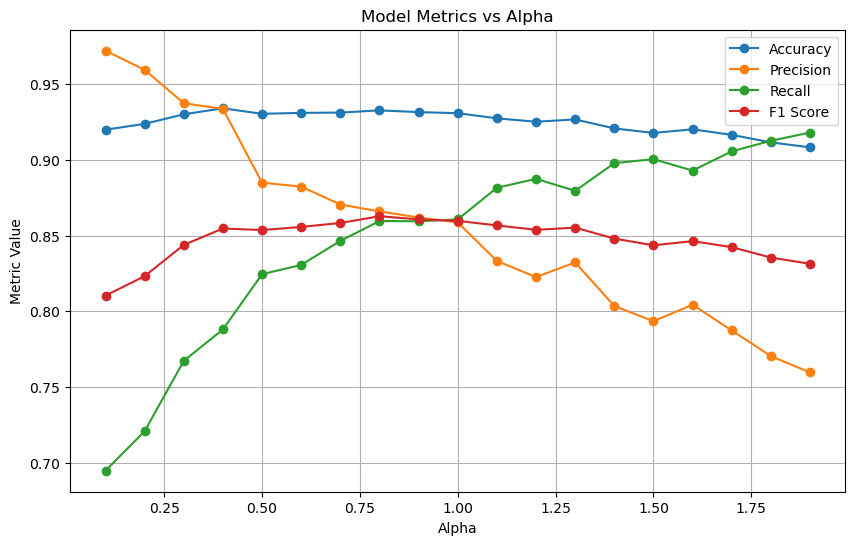

In [ ]:
# Determining the change in the metrics and the model 'priority' with change in beta
metrics = []
for alpha in np.arange(0.1, 2, 0.1):
    metrics.append(train_cost_senistive(alpha))

#Plotting

import matplotlib.pyplot as plt

# Convert data to separate lists
betas = [row[0] for row in metrics]
accuracy = [row[1] for row in metrics]
precision = [row[2] for row in metrics]
recall = [row[3] for row in metrics]
f1 = [row[4] for row in metrics]

# Plot metrics vs alpha
plt.figure(figsize=(10, 6))
plt.plot(betas, accuracy, label='Accuracy', marker='o')
plt.plot(betas, precision, label='Precision', marker='o')
plt.plot(betas, recall, label='Recall', marker='o')
plt.plot(betas, f1, label='F1 Score', marker='o')

# Add labels, legend, and title
plt.xlabel('Alpha')
plt.ylabel('Metric Value')
plt.title('Model Metrics vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

**Key Takeaways:**

* We can see that as alpha increases, the recall increases and the precision decreases, thus priorioritzing predicting fewer false negatives, decreasing the risk for the bank.
* As alpha increases, we can also see that the accuracy remains relatively similar.

Import data so that we do not have to keep preprocessing.

In [ ]:
# Load .csv (text files)
X_train_smote_scaled = np.loadtxt('X_train_smote_scaled.csv', delimiter=',')
X_test_scaled = np.loadtxt('X_test_scaled.csv', delimiter=',')
y_train_smote = np.loadtxt('y_train_smote.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')


#**Part 5: Hyperparameter Tuning for the Models**

**Why RandomizedSearchCV?**

> - **Efficiency:** RandomizedSearchCV allows exploration of a wide range of hyperparameter combinations in less time than GridSearchCV.

> - **Scalability:** It is particularly effective for hyperparameters like learning_rate (continuous) and max_iter or n_estimators (integer), where an exhaustive search is computationally expensive.

> - **Avoiding Overfitting:** The randomized approach ensures we do not focus on a limited subset of the parameter space, reducing the risk of overfitting to the cross-validation data.

###**Part 5.1 : Hyperparameter Tuning for Logistic Regression**

We used Randomized Search to tune our hyperparameters as we want to explore a wide range of continuous values and this technique allows us to do the same in a much faster way.


####**Parameters:**

> `C: loguniform(1e-4, 100)` This controls the regularization strength in Logistic Regression. A smaller value indicates stronger regularization, while larger values reduce it. The ***log-uniform distribution*** was chosen because C typically spans several orders of magnitude, making a uniform distribution unsuitable. This ensures an efficient search over a wide range of meaningful values.

> `max_iter: randint(100, 501)` This determines the maximum number of iterations for the solver to converge. Random integers between 100 and 500 were chosen to account for ***potential convergence*** issues that might arise with larger datasets or complex feature spaces.

In [ ]:
param_distributions = {
    'C': loguniform(1e-4, 100),      # Random float from a log-uniform distribution
    'max_iter': randint(100, 501)     # Random integer between 100 and 500
}

model = LogisticRegression()

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    scoring='accuracy',
    cv=5,  # Cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

In [ ]:
# Fit the model on your training data
random_search.fit(X_train_smote_scaled, y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...............C=0.017670169402947963, max_iter=448; total time=   0.2s
[CV] END ................C=0.39079671568228835, max_iter=202; total time=   0.3s
[CV] END ...............C=0.047314746448150063, max_iter=314; total time=   0.2s
[CV] END .................C=1.7718847354806828, max_iter=249; total time=   0.3s
[CV] END .............C=0.00021800651586435218, max_iter=443; total time=   0.2s
[CV] END .............C=0.00010108171343846384, max_iter=376; total time=   0.1s
[CV] END .............C=0.00010108171343846384, max_iter=376; total time=   0.1s
[CV] END .................C=0.5068612120448913, max_iter=413; total time=   0.3s
[CV] END ................C=0.14077923139972406, max_iter=335; total time=   0.3s
[CV] END ................C=0.01578232781079559, max_iter=289; total time=   0.2s
[CV] END ..............C=0.0003496540855952736, max_iter=150; total time=   0.1s
[CV] END ................C=0.35849855803404745,

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...............C=0.017670169402947963, max_iter=448; total time=   0.2s
[CV] END ................C=0.39079671568228835, max_iter=202; total time=   0.3s
[CV] END .............C=0.00022310108018679258, max_iter=187; total time=   0.1s
[CV] END ...............C=0.010051981180656781, max_iter=459; total time=   0.2s
[CV] END .................C=1.7718847354806828, max_iter=249; total time=   0.3s
[CV] END .............C=0.00010108171343846384, max_iter=376; total time=   0.1s
[CV] END .................C=0.5068612120448913, max_iter=413; total time=   0.4s
[CV] END ................C=0.14077923139972406, max_iter=335; total time=   0.2s
[CV] END ................C=0.01578232781079559, max_iter=289; total time=   0.3s
[CV] END ................C=0.01971387269004537, max_iter=343; total time=   0.2s
[CV] END ................C=0.35849855803404745, max_iter=230; total time=   0.2s
[CV] END ..............C=0.0010547383621352044, max_iter=266; total time=   0.1s
[CV] END .............C=0.00

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16627a4b0>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x166257710>},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
# Display the best hyperparameters and corresponding performance
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Hyperparameters: {'C': 23.386439256208728, 'max_iter': 369}
Best Cross-Validation Score: 0.8155704323570433


In [ ]:
# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)

In [ ]:
# Classification report (includes precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     22406
         1.0       0.68      0.70      0.69      7328

    accuracy                           0.85     29734
   macro avg       0.79      0.80      0.80     29734
weighted avg       0.85      0.85      0.85     29734

Accuracy Score: 0.8470101567229434


**Key Takeaways:**

**Hyperparameter Tuning:** Logistic Regression's hyperparameters (C and max_iter) were optimized using RandomizedSearchCV, yielding the best configuration:
`C = 23.38, max_iter = 369.`

> Best cross-validation accuracy: 81.56%.

**Test Performance:**

> `Accuracy:` 84.70%.

> `Class 0 (Non-default)`: Precision = 90%, Recall = 89%.

> `Class 1 (Default)`: Precision = 68%, Recall = 70%.

**Conclusion:** While Logistic Regression serves as a baseline, its performance for the minority class (default) is limited, with lower recall and precision compared to other models. Despite our tuning efforts, there was no improvement, indicating that Logistic Regression has reached its optimal complexity for predicting this particular outcome.

###**Part 5.2 : Hyperparameter Tuning for Random Forest Classifier Model**

We used Randomized Search to tune our hyperparameters as we want to explore a wide range of continuous values and this technique allows us to do the same in a much faster way.


####**Parameters:**

> `n_estimators: randint(50, 201)` This is the number of trees in the forest. More trees generally ***improve performance*** but increase computation time. A range of 50–200 was chosen to balance accuracy and efficiency.

> `max_depth: randint(1, 21)` This controls the depth of each tree, which directly affects model complexity. A range of 1–20 ensures ***exploration of shallow trees (less complex, less overfitting) and deep trees (more complex, potentially more overfitting)***.

> `min_samples_split: randint(2, 6)` This determines the minimum number of samples required to split an internal node. A range of 2–5 ensures that splits are not overly ***sensitive to noise*** while still allowing flexibility in tree growth.

In [ ]:
param_distributions = {
    'n_estimators': randint(50, 201),  # Random int between 50 and 200
    'max_depth': randint(1, 21),        # Random int between 1 and 20
    'min_samples_split': randint(2, 6)  # Random int between 2 and 5
}

model = RandomForestClassifier()

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50,               # Number of random combinations to try
    scoring='accuracy',      # Evaluation metric
    cv=5,                    # Cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)

In [ ]:
random_search.fit(X_train_smote_scaled, y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x11d43c6b0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17f2ba5a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x165f3a9c0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Hyperparameters: {'max_depth': 19, 'min_samples_split': 3, 'n_estimators': 77}
Best Cross-Validation Score: 0.948881450488145


In [ ]:
# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)

In [ ]:
# Classification report (includes precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.96     22406
         1.0       0.95      0.82      0.88      7328

    accuracy                           0.95     29734
   macro avg       0.95      0.90      0.92     29734
weighted avg       0.95      0.95      0.94     29734

Accuracy Score: 0.9452478643976593


**Key Takeaways:**

**Hyperparameter Tuning:** Random Forest's best hyperparameters were:

`max_depth = 19, n_estimators = 77, min_samples_split = 3.`
> Best cross-validation accuracy: 94.89%.

**Test Performance:**

> `Accuracy:` 94.52%.

> `Class 0 (Non-default):` Precision = 94%, Recall = 99%.

> `Class 1 (Default):` Precision = 95%, Recall = 82%.

**Conclusion:** Random Forest significantly improves minority class predictions compared to Logistic Regression, achieving a good balance between ***recall (82%)*** and ***precision (95%)*** for class 1. Despite our tuning efforts, there was no improvement, which could be because RFC was already performing quite well and it is difficult to make further improvements with hyperparameter tuning.

###**Part 5.3 : Hyperparameter Tuning for XGBoost Model**

We used Randomized Search to tune our hyperparameters as we want to explore a wide range of continuous values and this technique allows us to do the same in a much faster way.


####**Parameters:**

> `learning_rate: uniform(0.1, 0.4)` This controls the contribution of each tree in the ensemble. Lower values often result in better generalization at the cost of requiring more trees. A uniform range of 0.1–0.4 was chosen to explore this trade-off.

> `n_estimators: randint(50, 201)` Similar to Random Forest, this controls the number of boosting rounds. A range of ***50–200 balances computational cost*** with model performance.

> `max_depth: randint(3, 11) ` Limits the maximum depth of individual trees. ***Shallower trees generalize better***, while deeper trees can capture more complex patterns. A range of 3–10 was chosen to ensure a mix of generalization and complexity.

In [ ]:
param_dist = {
    'learning_rate': uniform(0.1, 0.4),  # Uniform distribution from 0.1 to 0.4
    'n_estimators': randint(50, 201),    # Random integer between 50 and 200
    'max_depth': randint(3, 11)          # Random integer between 3 and 10
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    scoring='accuracy',
    cv=5,        # 5-fold cross-validation
    verbose=2,   # Display progress
    random_state=42,
    n_jobs=-1     # Use all available CPUs for parallel computation
)

In [ ]:
random_search.fit(X_train_smote_scaled, y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...............C=0.001559747953698376, max_iter=491; total time=   0.1s
[CV] END .................C=0.8062359381277655, max_iter=127; total time=   0.3s
[CV] END .................C=15.087613675681679, max_iter=427; total time=   0.3s
[CV] END .max_depth=7, min_samples_split=5, n_estimators=142; total time=  19.3s
[CV] END .max_depth=7, min_samples_split=3, n_estimators=124; total time=  18.5s
[CV] END max_depth=11, min_samples_split=5, n_estimators=166; total time=  33.9s
[CV] END ..max_depth=2, min_samples_split=5, n_estimators=70; total time=   5.1s
[CV] END .max_depth=1, min_samples_split=5, n_estimators=107; total time=   4.7s
[CV] END .max_depth=12, min_samples_split=2, n_estimators=98; total time=  22.0s
[CV] END max_depth=15, min_samples_split=3, n_estimators=100; total time=  25.6s
[CV] END .max_depth=3, min_samples_split=2, n_estimators=100; total time=  11.1s
[CV] END .max_depth=7, min_samples_split=2, n_e

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .................C=2.3661540064603184, max_iter=388; total time=   0.3s
[CV] END .................C=0.8062359381277655, max_iter=127; total time=   0.3s
[CV] END max_depth=15, min_samples_split=4, n_estimators=121; total time=  25.0s
[CV] END .max_depth=7, min_samples_split=3, n_estimators=124; total time=  17.7s
[CV] END max_depth=11, min_samples_split=5, n_estimators=166; total time=  33.8s
[CV] END ..max_depth=2, min_samples_split=5, n_estimators=70; total time=   4.8s
[CV] END .max_depth=12, min_samples_split=2, n_estimators=98; total time=  22.3s
[CV] END max_depth=15, min_samples_split=3, n_estimators=100; total time=  25.4s
[CV] END .max_depth=3, min_samples_split=2, n_estimators=100; total time=  11.5s
[CV] END .max_depth=7, min_samples_split=2, n_estimators=122; total time=  20.2s
[CV] END .max_depth=14, min_samples_split=3, n_estimators=58; total time=  14.6s
[CV] END .max_depth=14, min_samples_split=3, n_estimators=58; total time=  15.0s
[CV] END .max_depth=15, min_

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16627be30>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1661dbd70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17f2bbfe0>},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)

Best Hyperparameters: {'learning_rate': 0.31587685295563195, 'max_depth': 10, 'n_estimators': 173}
Best Cross-Validation Score: 0.9917768479776848


In [ ]:
# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)

In [ ]:
# Classification report (includes precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     22406
         1.0       0.99      0.97      0.98      7328

    accuracy                           0.99     29734
   macro avg       0.99      0.98      0.99     29734
weighted avg       0.99      0.99      0.99     29734

Accuracy Score: 0.9908522230443264


**Key Takeaways:**

**Hyperparameter Tuning:** XGBoost's optimal hyperparameters were:
`learning_rate = 0.33, max_depth = 6, n_estimators = 169.`

> Best cross-validation accuracy: 99.17%.

**Test Performance:**

> `Accuracy:` 99%.

> `Class 0 (Non-default):` Precision = 99%, Recall = 100%.

> `Class 1 (Default):` Precision = 99%, Recall = 97%.

**Conclusion:** XGBoost outperforms both Logistic Regression and Random Forest by achieving high precision and recall for both classes, especially excelling in capturing minority class instances (default loans) with a ***recall of 97%***. Despite our tuning efforts, there was no improvement, which could be because XGB was already performing quite well and it is difficult to make further improvements with hyperparameter tuning.


###**Part 5.4 : Hyperparameter Tuning for Neural Networks**

We are going to use Cross-Validiation using K-folds to tune the hyperparameters of a Neural Network architecture on our training data. Since JAX does not natively support GridSearch CV or RandomizedSearchCV, we will write our own function to evaluate the model using a set of hyperparameters and number of folds.




Instead of recomputing our scaled SMOTE data, we saved it in CSV files and read the data from there.

In [ ]:
# Read the scaled training and test sets
X_train_smote_scaled = pd.read_csv('X_train_smote_scaled.csv')
X_test_scaled = pd.read_csv("X_test_scaled.csv")

# Read the target variables
y_train = pd.read_csv("y_train_smote.csv")
y_test = pd.read_csv("y_test.csv")

print("Data loaded successfully!")
# Convert DataFrames to JAX arrays
X_train_smote_scaled = jnp.array(X_train_smote_scaled.values)
y_train = jnp.array(y_train.values, dtype='int32').reshape(-1, 1) # Ensure y_train is 2D
X_test_scaled = jnp.array(X_test_scaled.values)
y_test = jnp.array(y_test.values, dtype='int32').reshape(-1, 1) # Ensure y_test is 2D

Data loaded successfully!


### **Part 5.4.1: Cross Validation Helper Functions**

To perform Cross-Validation, we divide the training data along K folds.
The following are the helper functions generating pseudorandom permutations of the indices of the data and dividing X and y along K folds:

In [ ]:
# Define helper functions for K-Cross Validation

def create_k_folds(X, y, k=5, seed=42):
    # Set PRNG key
    key = jax.random.PRNGKey(seed) # setting random key for reproducibility
    n_samples = X.shape[0]

    # Generate a shuffled array of indices of X
    indices = jax.random.permutation(key, jnp.arange(n_samples))

    # Split indices into k roughly equal parts
    fold_sizes = (n_samples // k) * jnp.ones(k, dtype=int)
    fold_sizes = fold_sizes.at[:n_samples % k].add(1) # Distribute the remainder
    current = 0
    folds = []
    for fold_size in fold_sizes:
        test_indices = indices[current:current + fold_size]
        train_indices = jnp.concatenate([indices[:current], indices[current + fold_size:]])
        folds.append((train_indices, test_indices))
        current += fold_size
    return folds # returns the shuffled indices along k folds as a list


def generate_k_fold_data(X, y, k=5, seed=42):

    if k == 1:  # If k is 1, perform a single train-test split (using this for evalutation)

        # Generate a shuffled array of indices
        key = jax.random.PRNGKey(seed) #random key for reproducibility
        n_samples = X.shape[0]
        indices = jax.random.permutation(key, jnp.arange(n_samples)) # shuffle up the indices of the data

        # Split the data (80% train, 20% test as an example)
        split_point = int(0.8 * n_samples)
        train_indices = indices[:split_point]
        test_indices = indices[split_point:]

        # Create the train-test split data
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        return [(X_train, y_train, X_test, y_test)] # Return as a list of one tuple

    else: # if k != 1, create k folds
        folds = create_k_folds(X, y, k=k, seed=seed) # call create_k_folds to get the k shuffled list of indices of data
        fold_data = []

        for train_indices, test_indices in folds:
            X_train_fold, y_train_fold = X[train_indices], y[train_indices]
            X_test_fold, y_test_fold = X[test_indices], y[test_indices]
            fold_data.append((X_train_fold, y_train_fold, X_test_fold, y_test_fold))

        return fold_data

### **Part 5.4.2: Defining the model for K-fold Cross Validation**

Here, we will construct our Neural Network model for performing k-fold cross validation

In [ ]:
## Define model that takes in hyperparameters and number of folds, and outputs the performance metrics

def CV_NN(seed=42, train=(X_train_smote_scaled, y_train), layer_sizes=[32,32,32], activation=nn.relu, learning_rate=0.01, k=2, batch_size=200, num_epochs=10, verbose=False, mode='CV', test=None):
    key=jax.random.PRNGKey(seed) #random key for reproducibility
    metrics = [] # for stroring the metrics for each set of hyperparameters
    # Splitting the key into two to avoid re-using keys
    key, data_key = jax.random.split(key,2)
    X, y = train
    # # Reshuffle the data after using SMOTE
    X, y = shuffle_data(X, y, data_key)

    # For cross-validation, split into k folds
    if mode=='CV':
        data = generate_k_fold_data(X, y, k=k, seed=seed)

    # For evaluation, use the entire training data for training and test data for evaluation
    if mode=='eval':
        data = [(X, y, test[0], test[1])]

    #Training K folds
    for i in range(k):
        X_train_shuffled, y_train_shuffled, X_test_shuffled, y_test_shuffled = data[i] # retrieve folded data
        model = MLFFNN(layer_sizes=layer_sizes, activation=activation) #initialize model
        init_variables = model.init(key, X_train_shuffled[:1])  # Initialize with a sample batch
        state = TrainState.create(
            apply_fn=model.apply,
            params=init_variables['params'],
            tx=optax.chain(
                optax.clip_by_global_norm(1.0), # Gradient clipping
                optax.adam(learning_rate=learning_rate)
            )
        )
        # Training step
        @jax.jit         # JAX just-in-time compilation
        # Calculating and applying gradients
        def train_step(state, X_batch, y_batch):
            def loss_fn(params):
                return compute_loss(params, model, X_batch, y_batch) #(Using Binary Cross-Entropy Loss)
            grads = jax.grad(loss_fn)(state.params) # Calculate gradients
            new_state = state.apply_gradients(grads=grads) # Gradient Descent
            return new_state
        for epoch in range(num_epochs):
            with tqdm(create_batches(X_train_shuffled, y_train_shuffled, batch_size), unit="batch", leave=False) as tepoch: # progress bar
                if verbose:
                    tepoch.set_description(f"Fold: {i+1} Epoch {epoch + 1}/{num_epochs}") # display progress bar
                for X_batch, y_batch in tepoch:
                    X_batch = jnp.array(X_batch)
                    y_batch = jnp.array(y_batch)

                    # Train step
                    state = train_step(state, X_batch, y_batch) # Calculating and applying gradients

        # # Evaluate the model
        test_accuracy, test_precision, test_recall, test_f1 = evaluate(state.params, model, X_test_shuffled, y_test_shuffled)
        metrics.append([test_accuracy, test_precision, test_recall, test_f1])
    metrics = np.array(metrics)
    return {'test_accuracy':metrics[:,0].mean(), 'test_prediction':metrics[:,1].mean(), 'test_recall':metrics[:,2].mean(), 'test_f1':metrics[:,3].mean()}

### **Part 5.4.3: Hyperparameter Tuning**

Now that we have implemented all the helper functions we need, we will start hyperparameter tuning.

####**Parameters:**

`layer_list: [[64], [128, 64], [128, 64, 32]]`
> Different layer configurations can impact the model’s ability to learn complex patterns. A small number of layers (e.g., [64]) may underfit, while more layers (e.g., [128, 64, 32]) can capture more complex relationships but may risk overfitting. The choice of this range explores different architectures to find the optimal balance between complexity and generalization.

`learning_rate: [0.001, 0.01, 0.1]`
> A smaller learning rate results in slower convergence but allows for finer, more precise updates to weights, potentially improving accuracy. A larger learning rate accelerates convergence but can overshoot the optimal solution, leading to instability or poor generalization. The selected values test a range of possible learning rates to find the correct balance of how fine we want our updates to be.

`num_epochs: [50, 100]`
> Too few epochs may lead to underfitting, as the model may not learn enough from the data. Too many epochs may result in overfitting, where the model memorizes the training data rather than generalizing. These values allows us to evaluate whether increasing the number of epochs improves model performance without leading to overfitting.

`batch_size: [100, 200]`
> A larger batch size leads to more stable gradients but requires more memory and may result in slower convergence. A smaller batch size makes the optimization process noisier, potentially finding better minima but at the cost of stability. The selected range tests how different batch sizes affect model generalization ability.

In [ ]:
%%capture
#Run Cross-Validation

# Define the param_grid
param_grid = {
    'layer_list': [[64], [128, 64], [128, 64, 32]],
    'learning_rate': [0.001, 0.01, 0.1],
    'num_epochs': [50, 100],
    'batch_size': [100, 200]
}

# Function to run cross-validation for all parameter combinations
def run_cross_validation(param_grid, seed, X_train_smote_scaled, y_train, k=2):
    # Create all combinations of hyperparameters using itertools.product
    param_combinations = list(itertools.product(
        param_grid['layer_list'],
        param_grid['learning_rate'],
        param_grid['num_epochs'],
        param_grid['batch_size']
    ))

    results = []
    # Iterate through all combinations of hyperparameters
    for i in trange(len(param_combinations)):
        layer_sizes, learning_rate, num_epochs, batch_size = param_combinations[i]
        # Call your cross-validation function with the current set of hyperparameters
        metrics = CV_NN(
            seed=seed,
            train=(X_train_smote_scaled, y_train),
            layer_sizes=layer_sizes,
            activation=nn.relu,
            learning_rate=learning_rate,
            k=k,
            batch_size=batch_size,
            num_epochs=num_epochs
        )

        results.append({
            'layer_sizes': layer_sizes,
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'metrics': metrics
        })

    return results

# Run cross-validation for all parameter combinations
results = run_cross_validation(param_grid, 42, X_train_smote_scaled, y_train, k=5)

In [ ]:
#print the metrics corresponding to hyperparamaters
df = pd.DataFrame([{
    **result,
    **result['metrics'] # Flatten the metrics dictionary
} for result in results]).drop(columns=['metrics'])

# Display the table
df

,layer_sizes,learning_rate,num_epochs,batch_size,test_accuracy,test_prediction,test_recall,test_f1
0,[64],0.001,50,100,0.946226,0.955505,0.936039,0.945670
1,[64],0.001,50,200,0.945194,0.956559,0.932745,0.944498
2,[64],0.001,100,100,0.948228,0.956086,0.939625,0.947778
3,[64],0.001,100,200,0.947526,0.958630,0.935413,0.946876
4,[64],0.010,50,100,0.947297,0.958689,0.934907,0.946634
5,[64],0.010,50,200,0.948468,0.954214,0.942185,0.948145
6,[64],0.010,100,100,0.948669,0.962753,0.933471,0.947875
7,[64],0.010,100,200,0.949227,0.954089,0.943913,0.948954
8,[64],0.100,50,100,0.902019,0.907066,0.896247,0.901428
9,[64],0.100,50,200,0.919168,0.942961,0.892432,0.916965


In [ ]:
# Find the parameters of the row with the highest accuracy
best_accuracy_idx = df['test_accuracy'].idxmax()
best_params = df.loc[best_accuracy_idx]
# Display the best parameters and the corresponding accuracy
print("Best Parameters:")
print(best_params)

Best Parameters:
layer_sizes        [128, 64]
learning_rate          0.001
num_epochs                50
batch_size               100
test_accuracy       0.949567
test_prediction     0.954556
test_recall           0.9441
test_f1             0.949291
Name: 12, dtype: object


In [ ]:
#Train best model on best hyperparamters and evaluating on test data
metrics = CV_NN(seed=42, train=(X_train, y_train),
                layer_sizes=[128, 64], activation=nn.relu,
                learning_rate=0.001, k=1, batch_size=100, num_epochs=50, verbose=True,mode='eval', test=(X_test_scaled, y_test))   #set number of folds to 1 to get training data
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

test_accuracy: 0.93
test_prediction: 0.89
test_recall: 0.82
test_f1: 0.85


**Key Takeaways:**

**Hyperparameter Tuning:** Neural Networks best hyperparameters were:

`layer_sizes = [128, 64], learning_rate = 0.001, num_epochs = 50, batch_size = 100.`
> Best cross-validation accuracy: 95%.

**Test Performance:**

> `Accuracy:` 93%.

> `Precision:` 89%,

>  `Recall:` 82%.

**Conclusion:** Neural Networks significantly improve minority class predictions compared to Logistic Regression, achieving a good balance between ***recall (82%)*** and ***precision (89%)***. However, this model's performance is lower than XGB and slighly worse than RFC, indicating that a Neural Network is not really the best way to predict the given data. One possible reason for this could be that tree-based methods, might be better suited for this problem. These tree-based models often perform well with structured/tabular data because they can effectively capture non-linear relationships and interactions between features, without the need for extensive feature scaling or pre-processing. Additionally, tree-based methods are less sensitive to noise in the data and tend to be more robust, particularly when the data contains a mix of continuous and categorical features. Despite our tuning efforts, there was no improvement, which could be because there is still noise in the data and our NN does not handle noise well. So, we believe that this data is not suitable for Neural Networks.


# **Part 6: Posthoc Analysis of the Usefulness of SMOTE**

We took a decision to handle the class imbalance using SMOTE because of the 75-25 split in our data. Now we want to see if the decision we took was good or not. We will test our ML models without SMOTE and with SMOTE to see their performance and compare them.

## Part 6.1: Without SMOTE

Here, we will replicate all the steps of our implementation, except for SMOTE.

In [ ]:
# Step 1: Prepare the data
X = data.drop(columns=['Status', 'ID', 'year', 'Credit_Worthiness', 'open_credit',
                       'interest_only', 'lump_sum_payment', 'construction_type',
                       'Secured_by', 'total_units', 'Security_Type', 'Gender', 'age'], axis=1)
y = data['Status']


# Split into train and test sets with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Fill nulls in categorical columns using mode of training data
categorical_cols = X_train.select_dtypes(exclude=["number"]).columns
for col in categorical_cols:
    mode_value = X_train[col].mode()[0]  # Calculate mode of training column
    X_train[col] = X_train[col].fillna(mode_value)  # Fill training data
    X_test[col] = X_test[col].fillna(mode_value)  # Fill test data with training mode

# Step 3: One-Hot Encoding
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_cols])

# Clean feature names
feature_names = [
    name.replace("[", "").replace("]", "").replace("<", "_") for name in one_hot_encoder.get_feature_names_out(categorical_cols)
]

# Convert back to DataFrame for merging
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

# Drop original categorical columns and merge encoded columns
X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded_df)
X_test = X_test.drop(columns=categorical_cols).join(X_test_encoded_df)

# Step 4: Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Step 5: Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

# Check the class distribution after SMOTE
# class_distribution_after_smote = y_train_smote.value_counts()
# print("Class distribution after applying SMOTE:")
# print(class_distribution_after_smote)

# Step 6: Scale numeric columns only
numeric_cols = X_train.select_dtypes(include=["number"]).columns
scaler = StandardScaler()
X_train_scaled = X_train_imputed.copy()
X_test_scaled = X_test_imputed.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

We will analyse the model performance without SMOTE.

In [ ]:
# Step 7: Train Models
# Initialize models
lr_model = LogisticRegression()
rfc_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Train Logistic Regression
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Train Random Forest
rfc_model.fit(X_train_scaled, y_train)
y_pred_rfc = rfc_model.predict(X_test_scaled)

# Train XGBoost
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Step 8: Evaluate Models
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")

print("\nRandom Forest Classifier Results:")
print(classification_report(y_test, y_pred_rfc))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rfc):.2f}")

print("\nXGBoost Classifier Results:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     22406
           1       0.92      0.54      0.68      7328

    accuracy                           0.88     29734
   macro avg       0.90      0.76      0.80     29734
weighted avg       0.88      0.88      0.86     29734

Accuracy: 0.88

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     22406
           1       0.97      0.84      0.90      7328

    accuracy                           0.95     29734
   macro avg       0.96      0.92      0.93     29734
weighted avg       0.95      0.95      0.95     29734

Accuracy: 0.95

XGBoost Classifier Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22406
           1       0.99      0.95      0.97      7328

    accuracy                           0.98     29734
   ma

Train NN on non-smote data and evaluate performance


In [ ]:
# convert np to jax numpy arrays
X_train_scaled = jnp.array(X_train_scaled.values)
y_train = jnp.array(y_train.values, dtype='int32').reshape(-1, 1)  # Ensure y_train is 2D
X_test_scaled = jnp.array(X_test_scaled.values)
y_test = jnp.array(y_test.values, dtype='int32').reshape(-1, 1)  # Ensure y_test is 2D

In [ ]:
# Train NN on non-smote data and evaluate performance
metrics = CV_NN(seed=42, train=(X_train_scaled, y_train),
                layer_sizes=[128, 64], activation=nn.relu,
                learning_rate=0.001, k=1, batch_size=100, num_epochs=50, verbose=True,mode='eval', test=(X_test_scaled, y_test))   #set number of folds to 1 to get training data
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

test_accuracy: 0.94
test_prediction: 0.88
test_recall: 0.86
test_f1: 0.87


We will analyse the model performance with SMOTE.

In [ ]:
# Load .csv (text files)
X_train_smote_scaled = np.loadtxt('X_train_smote_scaled.csv', delimiter=',')
X_test_scaled = np.loadtxt('X_test_scaled.csv', delimiter=',')
y_train_smote = np.loadtxt('y_train_smote.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

In [ ]:
# Step 7: Train Models
# Initialize models
lr_model = LogisticRegression()
rfc_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Train Logistic Regression
lr_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_lr = lr_model.predict(X_test_scaled)

# Train Random Forest
rfc_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_rfc = rfc_model.predict(X_test_scaled)

# Train XGBoost
xgb_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Step 8: Evaluate Models
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")

print("\nRandom Forest Classifier Results:")
print(classification_report(y_test, y_pred_rfc))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rfc):.2f}")

print("\nXGBoost Classifier Results:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")

Logistic Regression Results:
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     22406
         1.0       0.68      0.70      0.69      7328

    accuracy                           0.85     29734
   macro avg       0.79      0.80      0.80     29734
weighted avg       0.85      0.85      0.85     29734

Accuracy: 0.85

Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     22406
         1.0       0.96      0.83      0.89      7328

    accuracy                           0.95     29734
   macro avg       0.95      0.91      0.93     29734
weighted avg       0.95      0.95      0.95     29734

Accuracy: 0.95

XGBoost Classifier Results:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     22406
         1.0       0.99      0.97      0.98      7328

    accuracy                           0.99     29734
   ma

In [ ]:
# convert np to jax numpy arrays
X_train_smote_scaled = jnp.array(X_train_smote_scaled.values)
y_train_smote = jnp.array(y_train_smote.values, dtype='int32').reshape(-1, 1)  # Ensure y_train is 2D
X_test_scaled = jnp.array(X_test_scaled.values)
y_test = jnp.array(y_test.values, dtype='int32').reshape(-1, 1)  # Ensure y_test is 2D

In [ ]:
# Train NN on SMOTE data and evaluate performance
metrics = CV_NN(seed=42, train=(X_train_smote_scaled, y_train_smote),
                layer_sizes=[128, 64], activation=nn.relu,
                learning_rate=0.001, k=1, batch_size=100, num_epochs=50, verbose=True,mode='eval', test=(X_test_scaled, y_test))   #set number of folds to 1 to get training data
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

test_accuracy: 0.93
test_prediction: 0.88
test_recall: 0.84
test_f1: 0.86


Key Takeaways:

* We can see that the accuracy of our models without SMOTE is slightly greater in Logistic Regression, but it's fairly even in RFC, XGB and NN.
* While the accuracy is slightly greater for Logistic Regression, we can see that the models without SMOTE are a lot more likely to predict 'Non-default' cases and that results in an increase in accuracy as 'Non-default' cases are more in number. However, the major drawback is that the recall is a lot lesser in this case as the number of False Negatives increases.
* A very high difference in recall is seen in Logistic Regression, but as the complexity of the models increases, the performance evens out. However, the NN performs slightly worse when we used SMOTE, which could be because SMOTE introduces some noise in our data and since we have a lot of outliers, the neural network is not able to perform as well. Having said that, the drop in performance of the NN is minimal. But in our highest performing model (XGB), our recall is still slightly higher when we use SMOTE that what it is when we do not, which further demonstrates it's ability to handle noise and outliers.
* It is better to have higher recall as it ensures that most of the customers who will default on the loan are correctly identified. In a financial context, missing a loan defaulter (false negative) could result in significant financial losses for the institution.


Therefore, we conclude that applying SMOTE to our data to handle class imbalance was a good idea.

# **Part 7: Compiled Results**

We will now compile the precision, recall, f1-score, and accuracy of all our models to see which model is the best.

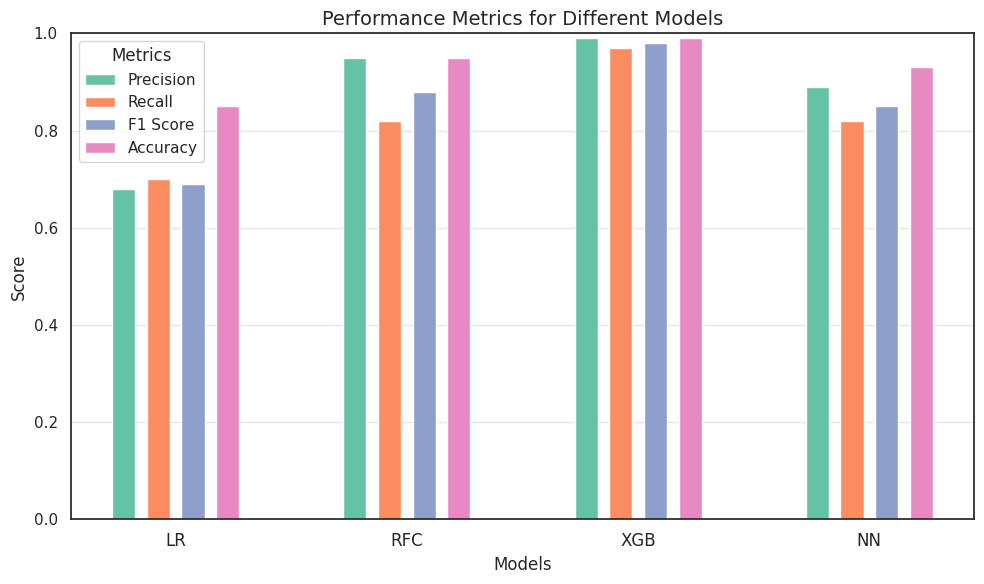

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample metric values for 4 models
models = ['LR', 'RFC', 'XGB', 'NN']

# Arrays for precision, recall, F1 score, and accuracy
precision = [0.68, 0.95, 0.99, 0.89]
recall = [0.70, 0.82, 0.97, 0.82]
f1_score = [0.69, 0.88, 0.98, 0.85]
accuracy = [0.85, 0.95, 0.99, 0.93]

# Combine all metrics into a single DataFrame
metrics_df = pd.DataFrame({
    'Model': models,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Accuracy': accuracy
})

# Custom spacing for bars
x_positions = np.arange(len(models))  # Base x positions for each model
bar_width = 0.1  # Width of each bar
spacing = 0.05  # Additional spacing between bars within a group

# Plot
plt.figure(figsize=(10, 6))
sns.set_theme(style="white")  # Clean theme without vertical grid lines

# Define the metrics and their colors
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
colors = sns.color_palette('Set2', n_colors=len(metrics))

# Manually plot each metric with spacing
for i, metric in enumerate(metrics):
    plt.bar(x_positions + i * (bar_width + spacing),
            metrics_df[metric],
            width=bar_width,
            label=metric,
            color=colors[i])

# Adjust x-ticks and labels
middle_bar_offset = (len(metrics) - 1) * (bar_width + spacing) / 2
plt.xticks(x_positions + middle_bar_offset, models, fontsize=12)

# Add only horizontal grid lines
plt.grid(axis='y', linestyle='solid', alpha=0.5)

# Add labels and title
plt.title('Performance Metrics for Different Models', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.ylim(0, 1)  # Since metrics are between 0 and 1
plt.legend(title='Metrics')

# Clean layout
plt.tight_layout()
plt.show()


Key Takeaways:

* Our XGB model performs the best among all the models we explored.
* The RFC and NN models showed significant improvement compared to our baseline Logistic Regression models.
* All our advanced models were able to capture the non-linear relationships of our data.

# **Part 8: Conclusion**

Key Takeaways:
* We ensured fairness in our models by excluding demographic factors (e.g., gender, age) that lack causal relationships with loan status. This decision prevents the model from learning unintended correlations and aligns with ethical principles.
* Feature selection was performed by removing irrelevant categorical columns, ensuring the inclusion of only useful predictors.
* To capture non-linear relationships in our data, we explored advanced techniques, including tree-based models (e.g., Random Forest, XGBoost) and Neural Networks (NN).
* Given the high volume of missing data, we employed advanced imputation techniques like the KNN Imputer, which effectively addressed null values and preserved data quality.
* Among all the models tested, XGBoost delivered the best performance, showcasing its ability to handle non-linear relationships and outliers with robustness.
* While hyperparameter tuning did not lead to improvements, this was likely because the models were already performing at a high baseline. This makes it more difficult to improve performance.
* By implementing cost-sensitive modeling in Neural Networks, we successfully prioritized reducing false negatives—a critical aspect aligned with the bank's risk management goals—while maintaining similar accuracy.
* Addressing class imbalance through SMOTE mostly resulted in higher recall and similar accuracies across our models, proving its effectiveness compared to imbalanced approaches.

Implications:
* The XGBoost model can significantly improve the bank's decision-making processes by accurately identifying potential defaulters and minimizing financial risks.
* Our cost-sensitive modeling in our NN demonstrates the ability to align technical model outcomes with broader business objectives, such as reducing default risks.
* Excluding demographic features aligns our work with ethical AI practices and supports fair, unbiased lending decisions, encouraging banks to avoid discrimination based on factors like gender or age.


Future Works:
* Incorporating domain-specific engineered features that capture more nuanced financial insights.
* Exploring advanced ensemble techniques like stacking and deep learning architectures such as Autoencoders to extract hidden features from the data to further enhance model performance.
* Explore similar datasets in the same domain to ensure generalizability and robustness in real-world scenarios.
* Considering explainable AI (XAI) methods to improve model transparency and build stakeholder trust.

Overall Experience + Team Reflection:

* Working on this project was a transformative learning experience that allowed us to integrate and apply the diverse skills we developed throughout the semester.
* Combining everybody's codes of different parts of the project together proved to be quite challenging and forced us to think early on about the design and flow of our project.
* While debugging and optimizing models proved challenging—such as resolving hyperparameter issues or understanding model-specific behavior—it reinforced the importance of iteration in data science. Constantly re-evaluating our assumptions and improving workflows made us appreciate the iterative nature of real-world problem-solving.
* Special thanks to Alan for his help and guidance throughout the project -- his contribution has not gone unnoticed :)

